# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.6 MB/s 
     |████████████████████████████████| 163 kB 65.9 MB/s 
     |████████████████████████████████| 7.6 MB 50.2 MB/s 


In [3]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
#% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!nvidia-smi

Wed Nov  9 03:42:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [5]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
#data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","nlp","'text gen demos'")
#filename = 'ra_top_1000_full.csv'

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/gdrive/


In [ ]:
# copy the data to the current Colab working directory
#!cp $data_dir/$filename .

In [6]:
# load into a data frame
filename = '/content/gdrive/MyDrive/NMEP Project/data/sequence-adl-piano-midi.csv'
df = pd.read_csv(filename)  
print(df)

       Unnamed: 0                                              input  \
0               0  Urban Contemporary song in the style of Debela...   
1               1  Urban Contemporary song in the style of Debela...   
2               2              Otacore song in the style of Sapphire   
3               3             Baile Pop song in the style of Wanessa   
4               4             Baile Pop song in the style of Wanessa   
...           ...                                                ...   
20072       20072       Jazz Guitar song in the style of Elek Bacsik   
20073       20073       Jazz Guitar song in the style of Jimmy Bruno   
20074       20074        Jazz Guitar song in the style of Ted Greene   
20075       20075       Jazz Guitar song in the style of Bobby Broom   
20076       20076       Jazz Guitar song in the style of Bobby Broom   

                                                sequence  
0      nGd160t288 nA#d160t288 nDd160t288 nDd46t48 nDd...  
1      nGd160t768

In [8]:
df.dropna(inplace=True)

In [9]:
sequences = df['sequence']

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


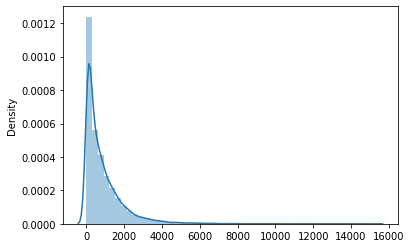

In [10]:
doc_lengths = []

for sequence in sequences:

    # get rough token count distribution
    tokens = nltk.word_tokenize(sequence)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [11]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.3824877902920363

In [12]:
np.average(doc_lengths)

860.2272500747533

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [19]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>', sep_token='<|sep|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))
print("The sep token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.sep_token_id), tokenizer.sep_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50259
The sep token <|sep|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [21]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [22]:
class GPT2Dataset(Dataset):

  def __init__(self, df, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for index, row in df.iterrows():

      encodings_dict = tokenizer('<|startoftext|>'+ row['input'] + '<|sep|>' + \
                                 row['sequence'] + '<|endoftext|>',
                                 truncation=True, max_length=max_length, 
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [23]:
dataset = GPT2Dataset(df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,059 training samples
2,007 validation samples


In [24]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [25]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [26]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [28]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [29]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,030. Loss: 1.2445050477981567.   Elapsed: 0:00:51.
0:  bipartisan"9339730354837483772d43d8579660655047d57d958d59d958d59d55d958d958d64d57d958d960d56d57d960d57d960d56d56d56d56d60d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d57d56d56d56d56d57d56d56d58d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d56d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,030. Loss: 1.506590485572815.   Elapsed: 0:01:43.
0:  increasingFd32t48 nG#d52t48 nEd1250t48 nEd1250t48 nD#d102t0 nAd128t0 nD#d128t0 nG#d192t0 nC#d192t0 nG#d192t0 nAd192t0 nEd96t0 nC#d96t0 nC#d94t0 nD#d92t0 nD#d92t0 nD#d96t0 nC#d98t0 nC#d97t0 nAd130t0 nAd130t0 nG#d128t0 nG#d128t0 nG#d128t0 nEd128t0 nG#d128t0 nD#d128t0 nD#d128t0 nG#d128t0 nD#d128t0 nG#d128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,030. Loss: 0.742316722869873.   Elapsed: 0:02:37.
0: day" song in the style of Robert WilliamsnBd1948t24 nC#d2096t24 nEd240t24 nBd30t48 nEd240t24 nBd35t48 nEd320t48 nBd60t48 nEd320t48 nC#d60t48 nEd160t48 nC#d120t48 nEd240t16 nC#d240t8 nEd240t8 nC#d240t8 nEd480t720 nEd480t720 nC#d480t720 nEd480t720 nEd480t720 nEd480t720 nBd720t720 nEd720t720 nBd720t720 nEd720t720 nBd720t720 nEd720t720 nEd720t720 nBd720t720 nC#d720t720 nEd720t720 nEd720t720 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,030. Loss: 0.8959923386573792.   Elapsed: 0:03:31.
0:  HangCountry song in the style of Johann Sebastian BachnDd0t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,030. Loss: 0.6176092028617859.   Elapsed: 0:04:23.
0:  foodsChoralean song in the style of The SoullessnFd28t6 nBd24t6 nG#d12t12 nEd24t6 nC#d12t12 nEd12t12 nEd12t12 nEd12t12 nC#d18t6 nG#d18t6 nD#d16t6 nC#d11t6 nBd12t6 nG#d20t6 nD#d20t6 nC#d36t6 nFd20t6 nEd40t6 nG#d40t6 nFd36t6 nEd40t6 nG#d36t6 nFd36t6 nD#d10t6 nFd0t6 nG#d30t6 nG#d30t6 nBd40t6 nEd40t6 nG#d40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,030. Loss: 0.9048181772232056.   Elapsed: 0:05:17.
0:  trailAoBd177t192 nGd180t192 nEd240t192 nCd240t192 nEd280t192 nCd280t192 nEd480t192 nCd480t192 nEd320t192 nCd320t192 nEd320t192 nCd320t192 nEd480t192 nCd480t192 nEd320t192 nAd360t192 nGd480t192 nCd480t192 nEd240t192 nDd240t192 nEd240t192 nEd240t192 nGd480t192 nCd240t192 nEd320t192 nAd360t192 nGd480t192 nCd240t192 nEd240t192 nDd240t192 nEd240t192 nGd480t192 nCd240t192 nEd240t192 nEd240t192 nAd360t192


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,030. Loss: 0.400113582611084.   Elapsed: 0:06:11.
0: intendC#d238t240 nF#d238t240 nG#d238t240 nC#d238t240 nDd238t240 nF#d238t240 nAd238t240 nC#d238t240 nF#d238t240 nG#d238t240 nC#d238t240 nDd238t240 nF#d238t240 nAd238t240 nC#d238t240 nF#d238t240 nC#d238t240 nDd238t240 nF#d238t240 nAd238t240 nC#d238t240 nF#d238t240 nC#d238t240 nDd238t240 nF#d238t240 nAd238t240 nC#d238t240 nF#d238t240 nC#d238t240 nDd238t240 nF#


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,030. Loss: 0.3214699327945709.   Elapsed: 0:07:05.
0:  surroundClassical song in the style of Bill EvansnC#d0t0 nFd0t0 nEd0t0 nG#d0t0 nG#d0t0 nBd0t0 nD#d0t0 nF#d0t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,030. Loss: 0.14662878215312958.   Elapsed: 0:07:58.
0:  reflexBd256t256 nDd256t256 nAd256t256 nBd256t256 nDd256t256 nAd256t256 nFd256t256 nFd256t256 nAd256t256 nFd256t256 nFd256t256 nAd256t256 nDd256t256 nAd256t256 nFd256t256 nFd256t256 nAd256t256 nFd256t256 nAd256t256 nDd256t256 nAd256t256 nGd256t256 nGd256t256 nDd256t256 nDd256t256 nAd256t256 nAd256t256 nGd256t256 nGd256t256 nFd256t256 nAd256t256 nDd256t256 nAd256t256 nAd256t256 nGd256t256 nGd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,030. Loss: 1.1229188442230225.   Elapsed: 0:08:52.
0:  displayDance Pop song in the style of Wolfgang Amadeus MozartnD#d960t960 nC#d960t960 nFd960t960 nFd960t960 nD#d960t960 nGd960t960 nGd960t960 nBd960t960 nC#d960t960 nFd960t960 nFd960t960 nGd960t960 nGd960t960 nFd960t960 nD#d960t960 nGd960t960 nGd960t960 nBd960t960 nC#d960t960 nFd960t960 nFd960t960 nC#d960t960 nFd960t960 nC#d960t960 nFd960t960 nGd960t960 nGd960t960 nGd960t960 nGd960t960 nF


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,030. Loss: 1.6462868452072144.   Elapsed: 0:09:46.
0:  pastorDance Pop song in the style of Dd360nDd360t360 nGd360t360 nDd360t360 nEd360t360 nF#d360t360 nBd360t360 nF#d360t360 nBd360t360 nEd360t360 nEd360t360 nF#d360t360 nBd360t360 nF#d360t360 nBd360t360 nDd360t360 nEd360t360 nF#d360t360 nBd360t360 nF#d360t360 nBd360t360 nGd360t360 nDd360t360 nEd360t360 nF#d360t360 nBd360t360 nF#d360t360 nBd360t360 nGd360t360 nDd360t360 nEd360t360 nF#d360


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,030. Loss: 0.7471445798873901.   Elapsed: 0:10:40.
0:  illicitSoft Rock song in the style of Steely DannDd0t0 nAd0t0 nAd0t0 nGd0t0 nGd0t0 nDd0t0 nCd0t0 nAd0t0 nAd0t0 nFd0t0 nEd0t0 nAd0t0 nCd0t0 nGd0t0 nCd0t0 nFd0t0 nAd0t0 nDd0t0 nAd0t0 nAd0t0 nFd0t0 nCd0t0 nAd0t0 nAd0t0 nAd0t0 nCd0t0 nAd0t0 nGd0t0 nDd0t0 nCd0t0 nDd0t0 nDd0t0 nAd0t0 nAd0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,030. Loss: 0.9742818474769592.   Elapsed: 0:11:35.
0:  LiberationAvant-Garde song in the style of Barbara AmienG#d62t60 nEd52t62 nG#d42t120 nEd57t120 nG#d58t60 nEd56t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45t60 nEd57t60 nG#d45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,030. Loss: 0.6734246611595154.   Elapsed: 0:12:29.
0:  NamVideo Game Music song in the style of The SimsnC#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t288 nF#d128t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,030. Loss: 0.6042177081108093.   Elapsed: 0:13:23.
0: IONJazz Funk song in the style of The A-HanDd240t240 nFd240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t240 nF#d240t240 nA#d240t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,030. Loss: 1.6665610074996948.   Elapsed: 0:14:17.
0:  glimpseUnknown song in the style of Andrew Lloyd WebbernG#d0t192 nD#d0t192 nFd0t192 nG#d192t192 nD#d0t192 nFd0t192 nG#d0t192 nG#d0t192 nG#d0t192 nG#d0t192 nBd0t192 nD#d0t192 nD#d0t192 nBd0t192 nG#d0t192 nD#d0t192 nBd0t192 nG#d0t192 nD#d0t192 nBd0t192 nG#d0t192 nG#d0t192 nG#d0t192 nG#d0t192 nG#d0t192 nG#d0t192 nG#d0t192 nD#d0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,030. Loss: 0.9766612648963928.   Elapsed: 0:15:11.
0:  LaureAustralian Indie song in the style of Neil DiamondnA#d0t192 nC#d240t192 nGd0t192 nEd0t192 nGd192t192 nFd192t192 nF#d192t192 nGd192t192 nA#d192t192 nGd192t192 nC#d192t192 nGd192t192 nA#d192t192 nGd192t192 nC#d192t192 nGd192t192 nF#d192t192 nGd192t192 nA#d192t192 nGd192t192 nC#d192t192 nGd192t192 nA#d192t192 nGd192t192 nC#d192t192 nGd192t192 nF#d192t192 nGd192t192 nA#d192t192 nG


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,030. Loss: 1.3050811290740967.   Elapsed: 0:16:05.
0: ismLounge song in the style of Richard ClaydermannFd0t384 nFd0t384 nFd0t384 nFd0t384 nCd0t384 nFd0t384 nAd0t384 nCd0t384 nFd0t384 nAd0t384 nAd0t384 nCd0t384 nAd0t384 nDd0t384 nCd0t384 nFd0t384 nCd0t384 nFd0t384 nAd0t384 nFd0t384 nFd0t384 nFd0t384 nGd0t384 nDd0t384 nFd0t384 nFd0t384 nEd0t384 nCd0t384 nGd0t384 nDd0t384 nFd0t384 nGd0t384 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,030. Loss: 0.8666381239891052.   Elapsed: 0:16:59.
0: ounVideo Game Music song in the style of Legend of Zelda: Ocarina of TimenA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nA#d30t120 nAd30t120 nGd30t120 nA#d30t120 nA#d30t120 nAd30t120 nGd30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,030. Loss: 0.2571569085121155.   Elapsed: 0:17:53.
0:  electionNew Mexico song in the style of Carl DouglasnCd64t2 nFd68t128 nEd66t2 nCd66t128 nFd71t128 nGd74t2 nFd69t128 nEd71t128 nGd79t128 nCd77t128 nEd78t128 nCd82t128 nEd86t128 nCd90t128 nEd93t128 nEd105t128 nCd106t128 nEd94t128 nCd98t128 nEd101t128 nCd118t128 nEd104t128 nCd105t128 nEd99t128 nCd110t128 nEd124t128 nCd114t128 nEd114t128 nCd127t128 nEd112t128 nCd116t128 nEd120t128 nCd136t128 nEd110t128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,030. Loss: 0.6748218536376953.   Elapsed: 0:18:47.
0:  crazyEuropop song in the style of BoneynDd0t48 nBd0t48 nDd0t48 nBd0t48 nBd0t48 nEd0t48 nEd0t48 nDd0t48 nGd0t48 nAd0t48 nCd0t48 nEd0t48 nDd0t48 nGd0t48 nDd0t48 nBd0t48 nBd0t48 nEd0t48 nAd0t48 nEd0t48 nDd0t48 nGd0t48 nAd0t48 nCd0t48 nEd0t48 nDd0t48 nGd0t48 nAd0t48 nEd0t48 nGd0t48 nEd0t48 nDd0t48 nGd0t48 nCd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,030. Loss: 0.7072155475616455.   Elapsed: 0:19:41.
0:  benchAlbum Rock song in the style of Barry WhitenCd0t96 nEd0t96 nEd0t96 nCd0t96 nEd0t96 nGd0t96 nEd0t96 nEd0t96 nCd0t96 nEd0t96 nCd0t96 nEd0t96 nCd0t96 nEd0t96 nCd0t96 nEd0t96 nCd0t96 nCd0t96 nEd0t96 nCd0t96 nCd0t96 nEd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 nCd0t96 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,030. Loss: 0.8389530777931213.   Elapsed: 0:20:35.
0:  incorporatedClassical Performance song in the style of Johann Sebastian BachnBd60t120 nAd60t120 nF#d60t120 nBd60t120 nAd60t120 nGd60t120 nF#d60t120 nBd60t120 nAd60t120 nGd60t120 nF#d60t120 nBd60t120 nAd60t120 nGd60t120 nF#d60t120 nBd60t120 nAd60t120 nGd60t120 nF#d60t120 nBd60t120 nAd60t120 nGd60t120 nF#d60t120 nBd60t120 nAd60t120 nGd60t120 nF#d60t120 nBd60t120 nAd60t120 nGd60t120 nF#d60t120 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,030. Loss: 1.166324496269226.   Elapsed: 0:21:29.
0: PeterVideo Game Music song in the style of Secret of EvermorenBd288t96 nBd384t96 nBd768t96 nBd1232t96 nGd1232t96 nCd1232t96 nFd1232t96 nBd1232t96 nFd768t96 nDd1232t96 nCd1232t96 nCd1232t96 nAd1232t96 nGd1344t288 nCd1152t288 nAd1152t288 nGd1152t288 nCd1152t288 nAd1152t288 nGd1152t288 nCd1152t288 nAd1152t288 nGd1152t288 nCd1152t288 nAd1152t288 nGd1152t288 nCd1152t288 nAd1152t288


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,030. Loss: 0.5569886565208435.   Elapsed: 0:22:23.
0: uringAlbum Rock song in the style of BostonnDd621t621 nF#d618t621 nC#d618t621 nAd646t646 nDd645t645 nF#d656t655 nC#d656t655 nBd658t658 nF#d660t660 nAd717t717 nF#d719t719 nBd719t719 nDd725t725 nF#d725t725 nBd725t725 nC#d625t625 nAd721t721 nF#d720t720 nF#d720t720 nC#d700t700 nAd749t749 nF#d720t720 nF#d720t720 nC#d650t650 nAd721t721 nF#d840t960 nF#d840t960


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,030. Loss: 1.02419912815094.   Elapsed: 0:23:17.
0:  reproductiveUnknown song in the style of LaiynD#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nBd24t24 nD#d24t24 nF#d24t24 nB


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,030. Loss: 0.573192834854126.   Elapsed: 0:24:11.
0:  zoneUnknown song in the style of Ricky MartinnCd1920t1920 nGd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nCd1920t1920 nCd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nGd1920t1920 nCd1920t1920 nCd1920t1920 nGd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920t1920 nCd1920t1920 nGd1920


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,030. Loss: 1.0208228826522827.   Elapsed: 0:25:05.
0:  commitsCountry Rock song in the style of Robbie WilliamsnG#d766t960 nCd764t960 nG#d766t960 nFd766t960 nG#d766t960 nC#d766t960 nA#d766t960 nFd766t960 nD#d766t960 nFd766t960 nFd766t960 nA#d766t960 nFd766t960 nD#d766t960 nFd766t960 nF#d766t960 nC#d766t960 nA#d766t960 nD#d766t960 nFd766t960 nG#d766t960 nC#d766t960 nA#d766t960 nD#d766t960 nFd766


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,030. Loss: 0.9644566774368286.   Elapsed: 0:25:59.
0:  ironyUnknown song in the style of Michael BublénAd14t14 nGd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14t14 nAd14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,030. Loss: 0.5915408730506897.   Elapsed: 0:26:53.
0:  SahVideo Game Music song in the style of Legend of MananDd120t120 nDd120t120 nDd120t120 nDd120t120 nDd120t120 nDd120t120 nDd120t120 nAd120t120 nDd120t120 nDd120t120 nFd120t120 nAd120t120 nEd120t120 nGd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 nEd120t120 nGd120t120 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,030. Loss: 1.4203028678894043.   Elapsed: 0:27:47.
0:  BryanVideo Game Music song in the style of Final Fantasy 8nF#d2389t2252 nF#d3328t2212 nAd2389t2252 nF#d2389t2252 nF#d3328t2212 nAd2389t2252 nF#d2389t2252 nF#d3328t2212 nAd2389t2252 nF#d2389t2252 nF#d3328t2212 nAd2389t2252 nF#d2389t2252 nF#d3328t2212 nAd2389t2252 nF#d2389t2252 nF#d3328t2212 nAd2389t2252 nF#d2389t2252 nF#d3328t2212 nAd2389t2252 nF#d2389t2252 nF#


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,030. Loss: 0.5248171091079712.   Elapsed: 0:28:41.
0:  spiritsGerman Singer-Songwriter song in the style of Jafie AminBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd240t240 nBd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,030. Loss: 1.0174381732940674.   Elapsed: 0:29:36.
0:  seesAlbum Rock song in the style of I Love MathnFd90t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 nFd60t60 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,030. Loss: 0.4665457308292389.   Elapsed: 0:30:30.
0:  hungryClassic Portuguese Pop song in the style of José Luis PausininGd176t120 nDd176t120 nFd184t180 nAd184t180 nGd184t180 nCd184t180 nCd176t120 nAd200t180 nAd200t180 nCd204t180 nAd184t180 nAd200t180 nCd204t180 nAd180t180 nAd200t180 nCd208t180 nAd172t120 nDd184t180 nFd180t180 nAd180t180 nGd176t180 nDd184t180 nFd184t180 nAd180t180 nGd200t180 nDd180t180 nFd200t180 nAd204t180 nGd176t180 nDd180t180 nFd200t180 nAd204t180 nGd200t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,030. Loss: 0.9345612525939941.   Elapsed: 0:31:25.
0:  PTSoft Rock song in the style of Whitney HoustonnCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd48t48 nCd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,030. Loss: 0.2845914959907532.   Elapsed: 0:32:20.
0: üClassical song in the style of Ludwig van BeethovennEd576t576 nGd576t576 nCd576t576 nAd576t576 nEd576t576 nAd576t576 nCd576t576 nGd576t576 nEd576t576 nAd576t576 nCd576t576 nEd576t576 nAd576t576 nCd576t576 nEd576t576 nGd576t576 nCd576t576 nAd576t576 nEd576t576 nCd576t576 nFd576t576 nBd576t576 nGd576t576 nEd576t576 nGd576t576 nDd576t576 nEd576t576 nGd576t576 nAd576t576 nBd576t576 nGd576t576 nEd576t576 nGd576t576 nCd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,030. Loss: 1.143932819366455.   Elapsed: 0:33:15.
0: ruceUnknown song in the style of Felix DvoraknC#d0t576 nFd0t576 nAd0t576 nGd0t576 nBd0t576 nDd0t576 nAd0t576 nGd0t576 nDd0t576 nGd0t576 nBd0t576 nDd0t576 nGd0t576 nC#d0t576 nFd0t576 nAd0t576 nGd0t576 nBd0t576 nDd0t576 nAd0t576 nFd0t576 nFd0t576 nEd0t576 nC#d0t576 nAd0t576 nDd0t576 nGd0t576 nDd0t576 nGd0t576 nBd0t576 nF#d0t576 nFd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,030. Loss: 0.9701727628707886.   Elapsed: 0:34:09.
0:  derivativesVideo Game Music song in the style of Final Fantasy 3nBd3136t3120 nBd2264t2160 nGd2264t2160 nBd1560t3072 nBd1572t3072 nF#d1572t1572 nF#d1572t1572 nD#d2264t2160 nBd1560t3072 nBd1572t3072 nD#d1056t1152 nEd1548t1152 nCd1536t1152 nDd1536t1152 nF#d1536t1152 nEd1536t1152 nBd1536t1152 nCd1536t1152 nEd1536t1152 nDd3072t3072 nF#d3072t3072 nEd3072t3072 nBd720t720 nDd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,030. Loss: 0.5103272795677185.   Elapsed: 0:35:04.
0: Pop Rock song in the style of MadonnanAd1437t10 nAd1437t10 nCd1437t10 nAd1437t10 nEd1140t3 nAd737t1 nEd737t1 nEd737t1 nEd2800t4 nEd1733t5 nCd1733t10 nGd1733t10 nFd1733t10 nFd3760t2 nFd3760t10 nDd3760t10 nAd3760t10 nCd3760t10 nAd3760t10 nEd1536t1 nGd1536t1 nFd1536t1 nAd1536t1536 nCd1536t1536 nAd1536t1 nEd1536t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,030. Loss: 0.9069200158119202.   Elapsed: 0:35:59.
0:  rememberingCumbia song in the style of La AmadanDd720t720 nBd720t720 nDd1080t1080 nF#d1080t1080 nAd1080t1080 nDd1080t1080 nF#d1080t1080 nAd1080t1080 nDd1080t1080 nCd1080t1080 nBd1080t1080 nDd1080t1080 nBd1080t1080 nBd1080t1080 nDd1080t1080 nAd1080t1080 nBd1080t1080 nDd1080t1080 nF#d1080t1080 nAd1080t1080 nDd1080t1080 nBd1080t1080 nBd1080t1080 nDd1080t1080 nAd1080t1080 nBd1080t1080 nDd1080t1080 nF#d1080t1080 nAd1080t1080 nDd1080t1080 nBd1080t1080 nBd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,030. Loss: 1.4539273977279663.   Elapsed: 0:36:54.
0:  SourcesUnknown song in the style of Friedrich BurgmüllernAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd0t256 nAd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,030. Loss: 1.6063475608825684.   Elapsed: 0:37:49.
0: emsPop Rock song in the style of Tears For FearsnGd0t192 nDd0t192 nGd0t192 nDd0t192 nDd0t192 nCd0t192 nEd0t192 nF#d0t192 nDd0t192 nAd0t192 nAd0t192 nDd0t192 nEd0t192 nFd0t192 nDd0t192 nDd0t192 nDd0t192 nCd0t192 nEd0t192 nAd0t192 nDd0t192 nDd0t192 nFd0t192 nDd0t192 nCd0t192 nAd192t192 nDd192t192 nFd192t192 nDd192t192 nCd192t192 nFd192t192 nDd192t192 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,030. Loss: 0.9007323980331421.   Elapsed: 0:38:43.
0: tzClassical Piano song in the style of Wolfgang Amadeus MozartnBd0t240 nEd0t240 nGd0t240 nGd0t240 nEd0t240 nBd0t240 nEd0t240 nGd0t240 nEd0t240 nBd0t240 nEd0t240 nGd0t240 nEd0t240 nEd0t240 nBd0t240 nEd0t240 nGd0t240 nEd0t240 nBd0t240 nEd0t240 nEd0t240 nEd0t240 nGd0t240 nBd0t240 nEd0t240 nEd0t240 nGd0t240 nEd0t240 nBd0t240 nEd0t240 nEd0t240 nGd0t240 nEd0t240 nEd0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,030. Loss: 1.553663969039917.   Elapsed: 0:39:38.
0: maticDance Rock song in the style of Steely DannGd72t96 nGd108t96 nGd124t96 nGd148t96 nCd136t96 nCd68t96 nCd62t96 nCd64t96 nCd62t96 nCd64t96 nCd64t96 nCd64t96 nCd64t96 nCd64t96 nCd68t96 nCd62t96 nCd64t96 nCd60t96 nCd62t96 nCd64t96 nCd64t96 nCd60t96 nCd62t96 nCd60t96 nCd64t96 nCd60t96 nCd61t96 nCd62t96 nCd61t96 nCd64t96 nCd62t96 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,030. Loss: 0.5881109833717346.   Elapsed: 0:40:33.
0:  syndNew Wave Pop song in the style of Janet JacksonnGd624t720 nGd624t720 nD#d720t960 nA#d960t960 nG#d960t960 nG#d960t960 nD#d960t960 nGd960t960 nGd960t960 nGd960t960 nGd960t960 nD#d960t960 nGd960t960 nA#d960t960 nG#d960t960 nG#d960t960 nD#d960t960 nGd960t960 nGd960t960 nGd960t960 nGd960t960 nG#d960t960 nG#d960t960 nD#d960t960 nGd960t960 nGd960t960 nG#d960t960 nD#d960t960 nA#


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,030. Loss: 1.0330373048782349.   Elapsed: 0:41:28.
0:  gamClassical song in the style of JanusnCd0t384 nCd0t384 nCd384t384 nCd768t384 nAd384t384 nF#d384t384 nGd384t384 nCd768t384 nFd384t384 nAd384t384 nAd384t192 nDd384t192 nCd768t192 nGd0t192 nEd384t192 nFd192t192 nDd384t192 nCd192t192 nBd192t192 nGd0t192 nBd192t192 nGd384t384 nGd384t384 nBd768t384 nGd0t192 nBd192t192 nGd384t384 nGd384t384 nBd768t384 nGd0t192 nBd192t192 nGd192t192


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,030. Loss: 0.7323658466339111.   Elapsed: 0:42:23.
0:  injuryBubble Trance song in the style of Bob DylannCd76t96 nFd96t96 nCd96t96 nCd192t192 nD#d192t192 nBd2496t2496 nFd2496t24 nBd192t192 nFd192t192 nGd192t192 nG#d192t192 nA#d384t192 nGd96t96 nG#d96t96 nDd192t192 nCd24288t24288 nFd24288t24288 nA#d288t288 nA#d480t288 nFd24288t24288 nFd24288t24288 nFd0t384 nFd0t384 nFd0t384 nFd0t384 nA#d0t384 nFd0t384 nFd0t384 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,030. Loss: 0.4301512837409973.   Elapsed: 0:43:18.
0: azaFrench Rock song in the style of Adolphe BarbirollinDd638t638 nEd646t638 nDd638t638 nEd638t638 nDd638t638 nEd638t638 nDd638t638 nEd638t638 nDd638t638 nEd638t638 nDd638t638 nEd646t638 nDd638t638 nEd646t638 nDd638t638 nEd638t638 nDd638t638 nEd646t638 nDd638t638 nEd646t638 nDd638t638 nEd646t638 nDd638t638 nEd646t638 nDd638t638 nEd646


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,030. Loss: 0.18828390538692474.   Elapsed: 0:44:12.
0:  membraneFrench Rock song in the style of Jacques ChoeursnF#d48t48 nC#d48t48 nAd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48 nC#d48t48 nEd48t48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,030. Loss: 1.0521156787872314.   Elapsed: 0:45:07.
0: ijingVocal Jazz song in the style of VanesenbergnFd1164t12 nAd1213t12 nDd1314t12 nCd1313t12 nFd1209t12 nEd1296t12 nGd1211t12 nCd1215t13 nFd1212t13 nFd1319t13 nCd1317t12 nCd1216t12 nEd1213t12 nCd1319t12 nAd1218t12 nAd1321t12 nDd1321t12 nCd1321t12 nFd1321t12 nAd1319t12 nDd1324t12 nCd1324t12 nFd1324t12 nAd1323t12 nDd1323t12 nCd1323t12 nAd1321t12 nFd1321t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,030. Loss: 0.24001748859882355.   Elapsed: 0:46:02.
0:  castClassic Italian Pop song in the style of Luca BazarnF#d66t6 nBd67t5 nF#d78t5 nF#d54t4 nG#d54t4 nG#d54t2 nA#d52t60 nC#d44t60 nD#d54t60 nA#d53t60 nA#d58t60 nF#d54t60 nBd63t60 nF#d62t60 nBd60t60 nF#d58t60 nBd56t60 nC#d54t60 nF#d54t60 nC#d54t60 nF#d66t6 nBd67t5 nF#d78t5 nF#d54t4 nG#d54t4 nG#d54t2 nA#d52t60 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,030. Loss: 0.31646814942359924.   Elapsed: 0:46:56.
0:  purchClassical song in the style of Jan Ladislav DusseknAd0t0 nBd0t0 nF#d0t0 nF#d0t0 nD#d0t0 nD#d0t0 nD#d0t0 nAd0t0 nC#d0t0 nAd0t0 nAd0t0 nEd0t0 nG#d0t0 nBd0t0 nBd0t0 nEd0t0 nBd0t0 nBd0t0 nEd0t0 nBd0t0 nBd0t0 nF#d0t0 nF#d0t0 nD#d0t0 nF#d0t0 nAd0t0 nBd0t0 nF#d0t0 nF#d0t0 nD#d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,030. Loss: 0.2242175191640854.   Elapsed: 0:47:50.
0:  shouldersVideo Game Music song in the style of Final Fantasy 2nFd1388t1480 nDd1388t1480 nAd1392t1480 nAd1387t1480 nFd1397t1480 nC#d1398t1480 nFd1399t1480 nFd13100t1480 nFd1398t1480 nAd1399t1480 nC#d1392t1480 nFd1397t1480 nFd1398t1480 nAd1399t1480 nC#d1392t1480 nFd1397t1480 nFd1398t1480 nAd1399t1480 nC#d1392t1480 nFd1397t1480 nFd1398t1480 nAd1399t1480 nC#d1392t1480 nFd13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,030. Loss: 0.6845428347587585.   Elapsed: 0:48:44.
0:  builtClassical song in the style of Giuseppe GiordinEd0t96 nBd0t96 nCd0t96 nEd0t96 nCd0t96 nCd0t96 nAd0t96 nF#d0t96 nEd0t96 nBd0t96 nGd0t96 nCd0t96 nBd0t96 nGd0t96 nBd0t96 nDd0t96 nGd0t96 nBd0t96 nEd0t96 nEd0t96 nCd0t96 nCd0t96 nAd0t96 nG#d0t96 nEd0t96 nAd0t96 nBd0t96 nCd0t96 nG#d0t96 nBd0t96 nBd0t96 nGd0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,030. Loss: 1.4075772762298584.   Elapsed: 0:49:38.
0:  openlySoft Rock song in the style of The Bar-KaysnF#d88t96 nF#d88t96 nGd0t96 nGd0t96 nGd0t96 nA#d0t96 nA#d0t96 nA#d0t96 nA#d0t96 nA#d0t96 nA#d0t96 nA#d0t96 nGd96t96 nFd96t96 nGd0t96 nGd0t96 nA#d0t96 nA#d0t96 nA#d96t96 nGd96t96 nFd96t96 nGd0t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,030. Loss: 0.893862247467041.   Elapsed: 0:50:32.
0:  haltedClassical song in the style of Johann Sebastian BachnF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t576 nF#d0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,030. Loss: 1.0600078105926514.   Elapsed: 0:51:26.
0:  NikOperatic Pop song in the style of EnyanF#d1348t1348 nDd1396t1348 nBd2348t2348 nG#d1348t1348 nD#d1396t1348 nA#d2348t2348 nF#d1348t1348 nBd2348t2348 nA#d1348t1348 nGd1396t1348 nF#d1396t1348 nBd2348t2348 nA#d1348t1348 nG#d1396t1348 nD#d1396t1348 nA#d2348t2348 nF#d1348t1348 nBd2348t2348 nA#d1348t1348 nGd1396t1348 nF#d1396t1348 nBd2348t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,030. Loss: 1.0600358247756958.   Elapsed: 0:52:20.
0:  tinDance Pop song in the style of Spice GirlsnA#d0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0t1240 nA#d0t1240 nDd0t1240 nGd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,030. Loss: 0.6159675121307373.   Elapsed: 0:53:14.
0:  clinicalClassical song in the style of Pyotr Ilyich TchaikovskynFd0t192 nD#d192t192 nGd192t192 nA#d192t192 nGd192t192 nD#d192t192 nCd192t192 nG#d192t192 nFd192t192 nD#d192t192 nA#d192t192 nC#d192t192 nA#d192t192 nF#d192t192 nC#d192t192 nD#d192t192 nD#d192t192 nA#d192t192 nGd192t192 nC#d192t192 nG#d192t192 nC#d192t192 nFd192t192 nA#d192t192 nFd192t192 nC#d192t192 nA#d192t192 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,030. Loss: 0.331998735666275.   Elapsed: 0:54:08.
0: lectionsUnknown song in the style of Nicolay Rimsky-KorsakovnAd0t60 nDd0t60 nDd0t60 nAd60t60 nCd60t60 nDd60t60 nCd0t60 nDd60t60 nAd60t60 nCd60t60 nAd0t60 nDd60t60 nDd60t60 nAd60t60 nCd60t60 nAd0t60 nDd60t60 nAd60t60 nDd60t60 nCd0t60 nDd60t60 nAd60t60 nCd60t60 nAd0t60 nDd60t60 nDd60t60 nAd60t60 nCd60t60 nAd0t60 nDd60t60 nDd60t60 nAd60t60 nCd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,030. Loss: 1.2884351015090942.   Elapsed: 0:55:02.
0: elsAlbum Rock song in the style of The Rolling StonesnA#d1908t1920 nAd2092t1920 nAd1340t1920 nFd1340t1920 nDd1340t1920 nCd1340t1920 nCd1216t1920 nCd21216t1920 nGd208t1920 nFd216t1920 nA#d208t1920 nFd1340t1920 nCd1220t1920 nCd1240t1920 nCd2036t1920 nGd208t1920 nFd216t1920 nA#d208t1920 nFd1340t1920 nCd1220t1920 nCd1240t1920 nCd1232t1920 nCd1232t1920 nCd1232t1920 nGd1232t1920 nFd1232t1920 nGd1232t1920 nA#


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,030. Loss: 0.9769457578659058.   Elapsed: 0:55:56.
0: labUnknown song in the style of Lacy J DaltonnF#d59t96 nAd119t96 nC#d59t96 nD#d59t96 nBd59t96 nAd59t96 nG#d59t96 nC#d59t96 nAd59t96 nF#d59t96 nAd59t96 nC#d59t96 nBd59t96 nAd59t96 nAd59t96 nG#d59t96 nC#d59t96 nAd59t96 nF#d59t96 nAd59t96 nC#d59t96 nBd59t96 nAd59t96 nAd59t96 nG#d59t96 nC#d59t96 nAd59t96 nF#d59t96 nAd59t96 nC#d59t96 nBd59t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,030. Loss: 0.9773243069648743.   Elapsed: 0:56:50.
0:  tripleClassical song in the style of Joseph HaydnnAd0t1920 nDd1920t1920 nCd1920t1920 nDd1920t1920 nGd1920t1920 nBd1920t1920 nAd1920t1920 nCd1920t1920 nAd1920t1920 nAd1920t1920 nF#d1920t1920 nF#d1920t1920 nEd1920t1920 nDd1920t1920 nDd1920t1920 nEd1920t1920 nBd1920t1920 nAd1920t1920 nAd1920t1920 nAd1920t1920 nC#d1920t1920 nG#d1920t1920 nDd1920t1920 nAd1920t1920 nF#d1920t1920 nAd1920t1920 nC#d1920t1920 nFd1920t1920 nG#d1920t1920 nBd1920t1920 nFd1920t1920 nEd1920t1920 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,030. Loss: 1.721834421157837.   Elapsed: 0:57:44.
0: 220Video Game Music song in the style of Final Fantasy Crystal ChroniclesnEd0t0 nAd0t0 nDd0t0 nF#d0t0 nAd0t0 nDd0t0 nF#d0t0 nAd0t0 nDd0t0 nF#d0t0 nAd0t0 nDd0t0 nF#d0t0 nEd0t0 nAd0t0 nDd0t0 nF#d0t0 nAd0t0 nDd0t0 nF#d0t0 nEd0t0 nAd0t0 nDd0t0 nF#d0t0 nAd0t0 nDd0t0 nF#d0t0 nEd0t0 nAd0t0 nEd0t0 nAd0t0 nDd0t0 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,030. Loss: 1.4964319467544556.   Elapsed: 0:58:38.
0:  SeeSoul song in the style of John BerrynGd12t1 nDd8t1 nGd8t1 nGd5t1 nDd5t1 nDd5t5 nGd0t6 nGd2t1 nGd3t1 nGd6t1 nDd6t1 nGd2t3 nGd5t1 nGd6t1 nDd6t1 nGd3t1 nGd6t1 nDd6t1 nGd2t3 nGd5t1 nGd6t1 nDd6t1 nGd3t1 nGd6t1 nDd6t1 nGd3t1 nGd6t1 nDd6t1 nGd2t1 nGd3t1 nGd6t1 nDd6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,030. Loss: 0.4029463827610016.   Elapsed: 0:59:32.
0: @@Classical song in the style of Johann Sebastian BachnEd0t768 nGd0t768 nBd0t768 nDd0t768 nGd0t768 nDd0t768 nDd0t768 nGd0t768 nBd0t768 nEd0t768 nGd0t768 nBd0t768 nGd0t768 nAd0t768 nEd0t768 nDd0t768 nDd0t768 nGd0t768 nGd0t768 nBd0t768 nDd0t768 nGd0t768 nDd0t768 nBd0t768 nC#d0t768 nF#d0t768 nDd0t768 nGd0t768 nF#d0t768 nEd0t768 nGd0t768 nBd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,030. Loss: 0.8698215484619141.   Elapsed: 1:00:26.
0:  hostRock En Espanol song in the style of Jose Luis PeralesnCd1432t1440 nAd1432t1440 nFd1533t1540 nCd1533t1540 nGd1533t1540 nGd1533t1540 nCd1533t1540 nEd1533t1540 nCd1533t1540 nAd1533t1540 nFd1533t1540 nCd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nGd1533t1540 nCd1533t1540 nG


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,030. Loss: 0.578549861907959.   Elapsed: 1:01:20.
0: rolePanpipe song in the style of PanpipesnDd192t192 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nBd0t576 nB


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,030. Loss: 1.05866539478302.   Elapsed: 1:02:14.
0: iacUnknown song in the style of Carlene Carter,nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,030. Loss: 1.0148462057113647.   Elapsed: 1:03:08.
0:  LDContemporary Vocal Jazz song in the style of Katie MeluanA#d100t2 nGd118t2 nGd100t2 nD#d118t118 nD#d100t2 nG#d100t2 nA#d100t190 nD#d100t2 nGd100t190 nG#d100t2 nG#d100t190 nD#d100t2 nA#d100t190 nD#d100t2 nGd100t190 nG#d100t2 nD#d100t190 nD#d100t2 nG#d100t190 nD#d100t2 nGd100t190 nG#d100t190 nD#d100t2 nGd100t190 nG#d100t190 nD#d100t2 nA#d100t190 nD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,030. Loss: 0.2788394093513489.   Elapsed: 1:04:02.
0:  ListenUnknown song in the style of Lea SalonganDd0t0 nAd0t0 nEd0t0 nCd0t0 nEd0t0 nCd0t0 nDd0t0 nAd0t0 nDd0t0 nGd0t0 nGd0t0 nF#d0t0 nBd0t0 nDd0t0 nGd0t0 nGd0t0 nBd0t0 nF#d0t0 nAd0t0 nBd0t0 nDd0t0 nGd0t0 nGd0t0 nAd0t0 nCd0t0 nCd0t0 nGd0t0 nAd0t0 nF#d0t0 nCd0t0 nDd0t0 nBd0t0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,030. Loss: 1.0130524635314941.   Elapsed: 1:04:56.
0:  dyUnknown song in the style of Mordecai ShehorinEd128t128 nC#d128t128 nG#d128t128 nBd128t128 nEd128t128 nAd128t128 nC#d128t128 nBd128t128 nEd128t128 nAd128t128 nC#d128t128 nBd128t128 nEd128t128 nAd128t128 nC#d128t128 nBd128t128 nEd128t128 nAd128t128 nC#d128t128 nBd128t128 nEd128t128 nAd128t128 nC#d128t128 nBd128t128 nEd128t128 nAd128t128 nC#d128t128 nBd128t128 nEd128t128 nAd128t128 nC#d128t128 nBd128t128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,030. Loss: 0.7128601670265198.   Elapsed: 1:05:50.
0:  DomesticClassic Schlager song in the style of Frank ZnDd1t2 nAd1t2 nDd1t2 nAd1t2 nAd1t2 nAd1t2 nDd1t2 nAd1t2 nAd1t2 nAd1t2 nDd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nDd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nDd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nDd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 nAd1t2 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,030. Loss: 0.3468128442764282.   Elapsed: 1:06:44.
0:  beneficiariesNew Age song in the style of Tom BarabasnEd480t480 nGd480t480 nEd960t480 nCd960t480 nGd960t480 nDd960t480 nEd480t480 nEd960t480 nAd960t480 nBd960t480 nEd960t480 nBd960t480 nEd960t480 nBd960t480 nEd960t480 nGd960t480 nEd960t480 nCd960t480 nGd960t480 nEd960t480 nBd960t480 nEd960t480 nBd960t480 nEd960t480 nGd960t480 nEd960t480 nCd960t480 nGd960t480 nEd960t480 nBd960t480 nEd960t480 nBd960t480 nEd960t480 nGd960t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,030. Loss: 0.60991370677948.   Elapsed: 1:07:38.
0:  TitlePop Rock song in the style of Sheryl CrownDd96t96 nEd96t96 nFd96t96 nFd96t96 nGd96t96 nDd96t96 nCd96t96 nGd96t96 nGd96t96 nFd96t96 nEd96t96 nGd96t96 nGd96t96 nCd96t96 nCd96t96 nGd96t96 nGd96t96 nEd96t96 nGd96t96 nDd96t96 nEd96t96 nFd96t96 nFd96t96 nGd96t96 nDd96t96 nCd96t96 nGd96t96 nGd96t96 nFd96t96 nEd96t96 nGd96t96 nGd96t96 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,030. Loss: 0.7542309761047363.   Elapsed: 1:08:32.
0:  μUnknown song in the style of The Mormon Tabernacle ChoirnA#d240t240 nAd240t240 nFd240t240 nCd240t240 nG#d240t240 nA#d240t240 nD#d240t240 nA#d240t240 nA#d240t240 nCd240t240 nAd240t240 nFd240t240 nFd240t240 nAd240t240 nCd240t240 nFd240t240 nCd240t240 nG#d240t240 nA#d240t240 nD#d240t240 nA#d240t240 nA#d240t240 nCd240t240 nAd240t240 nFd240t240 nFd240t240 nAd240t240 nCd240t240 nFd240t240 nCd240t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,030. Loss: 0.8878322839736938.   Elapsed: 1:09:26.
0:  sellingUnknown song in the style of John TeshnEd119t96 nC#d119t96 nC#d119t96 nC#d119t96 nEd119t96 nC#d119t96 nC#d119t96 nC#d119t96 nAd119t96 nC#d119t96 nAd119t96 nC#d119t96 nAd119t96 nC#d119t96 nAd119t96 nC#d119t96 nAd119t96 nBd119t96 nBd119t96 nAd119t96 nAd119t96 nC#d119t96 nAd119t96 nC#d119t96 nAd119t96 nAd119t96 nC#d119t96 nAd119t96 nC#d119t96 nAd119t96 nC#d119t96 nAd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,030. Loss: 0.40338683128356934.   Elapsed: 1:10:20.
0:  migrantSoft Rock song in the style of Melissa LewisnEd0t192 nEd192t192 nAd192t192 nEd192t192 nAd0t96 nEd96t96 nEd96t96 nEd384t192 nEd0t192 nEd192t192 nC#d192t192 nDd0t96 nD#d96t96 nD#d0t96 nC#d96t96 nEd96t96 nEd96t96 nEd96t96 nEd0t96 nEd192t192 nC#d192t192 nC#d384t192 nC#d192t192 nEd192t192 nEd192t192 nEd192t192 nC#d192t192 nEd192t192 nEd0t96 nEd96t96 nEd96t96 nEd384t192 nEd0t192 nEd192t192 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,030. Loss: 1.4975812435150146.   Elapsed: 1:11:15.
0: ivelyAlternative Rock song in the style of MusenF#d13t13 nF#d27t27 nF#d30t30 nG#d6t6 nF#d15t15 nD#d15t15 nF#d5t10 nD#d7t10 nA#d7t10 nF#d15t15 nD#d15t15 nA#d15t15 nD#d5t10 nF#d7t10 nG#d14t15 nD#d15t15 nF#d5t10 nD#d7t10 nA#d7t10 nF#d15t15 nD#d15t15 nA#d15t15 nD#d5t10 nF#d7t10 nG#d14t15 nD#d15t15 nF#d5t10 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,030. Loss: 1.2422282695770264.   Elapsed: 1:12:09.
0:  orderUnknown song in the style of The Rainbow OrchestranAd1914t1920 nBd1914t1920 nGd1914t1920 nEd1914t1920 nC#d1914t1920 nAd1914t1920 nC#d1914t1920 nEd1914t1920 nBd1914t1920 nDd1914t1920 nBd1914t1920 nF#d1914t1920 nAd1914t1920 nAd1914t1920 nGd1914t1920 nF#d1914t1920 nAd1914t1920 nAd1914t1920 nDd1914t1920 nBd1914t1920 nF#d1914t1920 nAd1914t1920 nAd1914t1920 nC#d1914t1920 nEd14t1920 nBd1914t1920 nDd1914t1920 nBd1914t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,030. Loss: 0.9392961263656616.   Elapsed: 1:13:04.
0:  VPNUnknown song in the style of YACHTnBd0t96 nDd96t96 nGd0t96 nAd0t96 nGd96t96 nAd96t96 nGd96t96 nFd96t96 nBd96t96 nGd96t96 nAd96t96 nGd96t96 nGd96t96 nCd96t96 nDd96t96 nCd96t96 nBd672t96 nDd768t96 nGd384t96 nDd0t96 nFd0t96 nBd96t96 nGd0t96 nAd0t96 nGd96t96 nAd96t96 nGd96t96 nFd96t96 nBd96t96 nGd96t96 nAd96t96 nGd96t96 nGd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,030. Loss: 0.5448230504989624.   Elapsed: 1:13:58.
0:  explanationChristian Punk song in the style of The BugglesnA#d0t0 nDd0t0 nA#d0t0 nDd0t0 nDd0t0 nA#d0t0 nDd0t0 nDd0t0 nA#d0t0 nDd0t0 nDd0t0 nDd0t0 nA#d0t0 nDd0t0 nDd0t0 nA#d0t0 nDd0t0 nDd0t0 nA#d0t0 nDd0t0 nDd0t0 nA#d0t0 nA#d0t0 nDd0t0 nA#d0t0 nDd0t0 nDd0t0 nA#d0t0 nDd0t0 nD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,030. Loss: 1.5112478733062744.   Elapsed: 1:14:52.
0:  BachUnknown song in the style of Louis GobbanBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd0t768 nBd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,030. Loss: 0.9571483135223389.   Elapsed: 1:15:46.
0:  folderClassical song in the style of Franz SchubertnCd0t512 nD#d0t512 nDd0t512 nFd0t512 nA#d0t512 nFd0t512 nFd0t512 nCd0t512 nA#d0t512 nD#d0t512 nD#d0t512 nA#d0t512 nA#d0t512 nFd0t512 nFd0t512 nA#d0t512 nA#d0t512 nFd0t512 nCd0t512 nA#d0t512 nA#d0t512 nFd0t512 nFd0t512 nA#d0t512 nA#d0t512 nA#d0t512 nFd0t512 nFd0t512 nA#d0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,030. Loss: 0.5506494045257568.   Elapsed: 1:16:40.
0:  buildingDance Rock song in the style of Pet Shop BoysnD#d3024t4 nGd3024t4 nA#d3028t4 nD#d303024t4 nGd3024t4 nA#d3028t4 nDd3024t4 nGd3024t4 nA#d3028t4 nD#d3024t4 nGd3024t4 nA#d3024t4 nDd3024t4 nGd3024t4 nA#d3024t4 nDd3024t4 nGd3024t4 nA#d3024t4 nDd3024t4 nGd3024t4 nA#d3024t4 nDd3024t4 nGd3024t4 nA#d3024t4 nDd3024t4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,030. Loss: 1.420586347579956.   Elapsed: 1:17:34.
0:  BabylonUnknown song in the style of Vanessa Carlton  MFSBnCd0t0 nEd0t0 nGd0t0 nFd0t0 nEd0t0 nAd0t0 nFd0t0 nCd0t0 nFd0t0 nFd0t0 nAd0t0 nBd0t0 nCd0t0 nAd0t0 nFd0t0 nAd0t0 nCd0t0 nEd0t0 nAd0t0 nFd0t0 nFd0t0 nAd0t0 nBd0t0 nCd0t0 nAd0t0 nFd0t0 nAd0t0 nCd0t0 nD#d0t0 nD#d0t0 nFd0t0 nAd0t0 nF#d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,030. Loss: 1.3497285842895508.   Elapsed: 1:18:29.
0: perialVideo Game Music song in the style of Final Fantasy 3nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94t96 nF#d94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,030. Loss: 1.0485633611679077.   Elapsed: 1:19:23.
0:  rentsUnknown song in the style of Dd20t3 nF#d19t1 nBd17t23 nBd28t8 nG#d27t11 nCd29t13 nF#d21t24 nEd20t23 nD#d35t10 nD#d20t23 nD#d24t23 nF#d26t26 nDd25t23 nG#d26t26 nBd17t19 nD#d8t6 nF#d20t12 nEd30t20 nBd15t23 nBd16t2 nG#d13t12 nCd25t17 nF#d22t13 nEd16t19 nD#d41t8 nC#d44t18 nEd55t16 nEd49t16 nEd45t16 nEd47t17 nEd40t9 nEd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,030. Loss: 0.6692259907722473.   Elapsed: 1:20:17.
0:  RegGospel song in the style of Bebe WinansnAd852t2 nF#d16t2 nDd32t1 nBd37t13 nF#d17t3 nC#d13t1 nAd15t11 nDd21t2 nF#d19t1 nAd12t1 nDd13t7 nBd14t9 nDd24t1 nF#d18t9 nAd20t3 nDd18t10 nBd26t1 nF#d17t2 nC#d13t2 nEd14t7 nG#d15t5 nBd16t17 nG#d15t1 nBd24t2 nG#d22t17 nEd15t1 nEd15t3 nEd15t18 nG#d17t3 nBd13t16 nG#


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,030. Loss: 0.36670392751693726.   Elapsed: 1:21:11.
0: olasClassical Era song in the style of Friedrich KuhlaunFd0t0 nAd0t0 nDd0t0 nCd0t0 nFd0t0 nCd0t0 nCd0t0 nFd0t0 nFd0t0 nGd0t0 nGd0t0 nEd0t0 nGd0t0 nDd0t0 nCd0t0 nCd0t0 nCd0t0 nCd0t0 nFd0t0 nEd0t0 nCd0t0 nGd0t0 nFd0t0 nCd0t0 nFd0t0 nEd0t0 nGd0t0 nGd0t0 nDd0t0 nCd0t0 nCd0t0 nEd0t

  Average training loss: 0.91
  Training epoch took: 1:21:28

Running Validation...
  Validation Loss: 0.82
  Validation took: 0:02:44

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,030. Loss: 0.4926568567752838.   Elapsed: 0:00:52.
0:  responsesUnknown song in the style of Brazilian Tropical OrchestranC#d94t94 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95 nC#d95t95


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,030. Loss: 0.9076305627822876.   Elapsed: 0:01:46.
0:  attendanceFunk song in the style of SupremesnAd14t30 nFd14t30 nEd14t30 nCd14t30 nDd14t30 nDd14t30 nFd14t30 nAd14t30 nFd14t30 nEd14t30 nCd14t30 nDd14t30 nDd14t30 nFd14t30 nAd14t30 nFd14t30 nEd14t30 nCd14t30 nDd14t30 nDd14t30 nFd14t30 nAd14t30 nFd14t30 nEd14t30 nCd14t30 nDd14t30 nFd14t30 nAd14t30 nFd14t30 nEd14t30 nCd14t30 nDd14t30 nDd14t30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,030. Loss: 1.0123709440231323.   Elapsed: 0:02:40.
0:  rigidAustralian Pop song in the style of Beverley CravennFd28t21 nAd28t21 nCd28t21 nFd29t21 nA#d26t21 nDd26t21 nCd26t21 nFd25t21 nA#d25t21 nDd25t21 nCd26t21 nFd26t21 nA#d26t21 nDd26t21 nCd26t21 nFd24t21 nA#d26t21 nDd26t21 nCd26t21 nFd26t21 nA#d26t21 nDd26t21 nCd26t21 nFd26t21 nA#d26t21 nDd26t21 nCd26t21 nFd26t21 nA#d26t21 nDd26t21 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,030. Loss: 0.4303569495677948.   Elapsed: 0:03:34.
0: groVideo Game Music song in the style of Pokemon Red Blue YellownG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nFd96t480 nG#d96t480 nCd96t480 nF


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,030. Loss: 1.058487892150879.   Elapsed: 0:04:28.
0:  GreEuropop song in the style of S Club JuniorsnFd92t192 nCd93t192 nGd93t192 nFd93t192 nCd93t192 nCd83t192 nD#d83t192 nCd83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD#d83t192 nCd83t192 nD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,030. Loss: 0.4823261499404907.   Elapsed: 0:05:22.
0: uraUnknown song in the style of Nicolay Rimsky-KorsakovnAd256t288 nDd384t480 nGd384t480 nFd768t720 nFd1488t1080 nDd960t0 nGd256t0 nFd1024t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,030. Loss: 0.7796469926834106.   Elapsed: 0:06:15.
0:  2020Album Rock song in the style of ChicagonGd40t48 nGd40t48 nDd80t48 nGd40t48 nDd40t48 nGd48t48 nDd24t48 nGd48t48 nDd48t48 nGd48t48 nDd72t48 nGd40t48 nDd48t48 nGd48t48 nDd24t48 nGd48t48 nDd24t48 nGd48t48 nDd48t48 nGd48t48 nDd48t48 nGd48t48 nDd48t48 nGd48t48 nDd48t48 nGd48t48 nDd48t48 nGd48t48 nDd48t48 nGd48t48 nDd48t48 nGd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,030. Loss: 0.6008788347244263.   Elapsed: 0:07:09.
0:  chargingAlternative Metal song in the style of HalestormsnCd60t60 nCd60t60 nEd120t30 nCd60t60 nCd60t60 nCd60t60 nCd60t60 nCd60t60 nDd60t60 nDd60t60 nDd60t60 nFd60t60 nCd60t60 nCd60t60 nCd60t60 nFd120t60 nCd60t60 nCd60t60 nFd60t60 nCd60t60 nFd60t60 nCd60t60 nFd60t60 nCd60t60 nFd60t60 nCd60t60 nFd60t60 nCd60t60 nFd60t60 nCd60t60 nFd60t60 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,030. Loss: 0.2766396701335907.   Elapsed: 0:08:03.
0:  SarSmooth Jazz song in the style of Gary BrownnCd1176t1196 nFd1276t1196 nAd1392t1196 nCd1392t1196 nEd1392t1196 nCd1444t1302 nAd1444t1302 nCd1520t1302 nFd1520t1302 nAd1520t1302 nCd1520t1302 nGd936t960 nCd936t960 nGd1188t960 nFd1520t1504 nCd1520t1504 nGd1520t1504 nAd1520t1504 nCd1520t1504 nFd1520t1504 nAd1520t1504 nCd1520t1504 nGd936t960 nCd936t960 nGd1188t960


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,030. Loss: 1.0313230752944946.   Elapsed: 0:08:58.
0:  JasAlbum Rock song in the style of Boz ScaggsnD#d48t48 nGd48t48 nG#d48t48 nF#d48t48 nG#d48t48 nA#d48t48 nD#d48t48 nG#d48t48 nF#d48t48 nG#d48t48 nA#d48t48 nD#d48t48 nG#d48t48 nF#d48t48 nG#d48t48 nA#d48t48 nD#d48t48 nG#d48t48 nF#d48t48 nG#d48t48 nA#d48t48 nD#d48t48 nG#d48t48 nF#d48t48 nG#d48t48 nA#d48t48 nD#d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,030. Loss: 1.5863935947418213.   Elapsed: 0:09:52.
0:  permitFunk song in the style of Bobby CocksnF#d58t4 nC#d58t4 nC#d58t6 nAd32t7 nG#d50t12 nAd56t12 nC#d58t10 nAd58t10 nF#d68t60 nEd50t120 nAd54t120 nF#d64t8 nEd56t2 nBd66t2 nG#d54t10 nBd54t16 nG#d54t16 nBd54t16 nG#d54t8 nC#d62t2 nF#d50t2 nC#d54t2 nAd56t8 nF#d38t58 nF#d34t2 nG#d34t2 nC#d36t2 nG#d36t2 nC#d36t8 nAd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,030. Loss: 0.5618153810501099.   Elapsed: 0:10:46.
0:  AdministratorClassical song in the style of Franz SchubertnAd0t128 nF#d0t128 nDd0t128 nBd0t128 nGd0t128 nF#d0t128 nDd0t128 nAd0t128 nBd0t128 nC#d0t128 nGd0t128 nAd0t128 nBd0t128 nC#d0t128 nEd0t128 nAd0t128 nBd0t128 nC#d0t128 nEd0t128 nEd0t128 nAd0t128 nEd0t128 nBd0t128 nC#d0t128 nEd0t128 nBd0t128 nC#d0t128 nEd0t128 nEd0t128 nF#d0t128 nAd0t128 nGd0t128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,030. Loss: 0.7402211427688599.   Elapsed: 0:11:40.
0:  EVENTSClassic Italian Pop song in the style of Luca BacchettinGd19t24 nGd15t24 nGd20t24 nAd20t24 nCd20t24 nCd0t21 nCd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21 nBd0t21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,030. Loss: 1.9646244049072266.   Elapsed: 0:12:34.
0:  Mental24242687t21 nFd9t0 nGd7 nGd0t0 nFd7t0 nEd#d7 nGd7t0 nEd#d9t0 nEdd0t0 nCd11t0 nGd9t0 nGd0t0 nGd9t0 nFd9t0 nGd9t0 nC#d9 nEdd6t0t0 nCd8 nDd9 nC#d16t14 nDd9t16 nEdd15t0 nC#d5t14 nG#d7t0 nBd9t14 nG#d9t18 nB#d9t14 nDd14t16 nG#d5t14t26 nG#d1 nD#d18t14t14 nG#d8t44t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,030. Loss: 0.7001309990882874.   Elapsed: 0:13:28.
0: idsPanpipe song in the style of PanpipesnGd0t960 nEd0t960 nGd0t960 nEd0t960 nGd0t960 nEd0t960 nGd0t960 nEd0t960 nGd0t960 nGd0t960 nEd0t960 nGd0t960 nEd0t960 nGd0t960 nEd0t960 nGd0t960 nGd0t960 nEd0t960 nEd0t960 nGd0t960 nEd0t960 nGd0t960 nGd0t960 nGd0t960 nEd0t960 nGd0t960 nEd0t960 nGd0t960 nGd0t960 nCd0t960 nGd0t960 nGd0t960 nCd0t960 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,030. Loss: 0.562375009059906.   Elapsed: 0:14:22.
0: ceansClassical Era song in the style of Wolfgang Amadeus MozartnA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d1536t1536 nA#d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,030. Loss: 0.6044263243675232.   Elapsed: 0:15:17.
0:  geneticallyEuropop song in the style of S Club 7nCd40t192 nCd39t192 nGd40t192 nCd32t192 nCd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nGd39t192 nCd39t192 nCd39t192 nGd39t192 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,030. Loss: 0.7326410412788391.   Elapsed: 0:16:11.
0:  adviceCanadian Indie song in the style of Léngol D-M#d76t75 nD#d79t79 nD#d84t96 nD#d104t96 nD#d104t96 nD#d104t96 nD#d104t96 nD#d103t95 nD#d103t95 nD#d103t95 nD#d105t96 nD#d102t96 nD#d102t96 nD#d102t96 nD#d102t96 nD#d102t95 nD#d102t96 nD#d102t96 nD#d102t95 nD#d102t95 nD#d102t95 nD#d102t96 nD#d102t95 nD#d102t95 nD#d102t96 nD#d102t95 nD#d102


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,030. Loss: 0.31716188788414.   Elapsed: 0:17:05.
0:  incompleteVideo Game Music song in the style of Max ManilownFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384 nFd1t384


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,030. Loss: 1.2253071069717407.   Elapsed: 0:17:59.
0: commentUnknown song in the style of Nana MouskourinBd20t15 nBd20t15 nAd15t15 nCd17t17 nAd13t13 nGd21t13 nBd18t13 nBd25t14 nCd32t11 nAd13t13 nGd26t13 nBd16t11 nAd19t11 nCd15t15 nEd13t16 nGd6t12 nCd6t12 nEd13t13 nGd10t4 nCd12t1 nEd12t1 nGd7t15 nCd6t12 nEd12t3 nGd7t4 nCd14t6 nGd7t1 nGd7t16 nDd7t1 nGd7t2 nCd14t15 nDd0t14 nAd3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,030. Loss: 1.6101571321487427.   Elapsed: 0:18:53.
0:  pilotClassical Piano song in the style of Andrei GavrilovnGd1534t1536 nBd1534t1536 nDd1534t1536 nEd1534t1536 nBd1534t1536 nDd1534t1536 nEd1534t1536 nGd1534t1536 nBd1534t1536 nDd1534t1536 nEd1534t1536 nGd1534t1536 nBd1534t1536 nDd1534t1536 nEd1534t1536 nGd1534t1536 nBd1534t1536 nDd1534t1536 nEd1534t1536 nGd1534t1536 nBd1534t1536 nDd1534t1536 nEd1534t1536 nGd1534t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,030. Loss: 0.515245258808136.   Elapsed: 0:19:47.
0: gersUnknown song in the style of Johann KügernCd192t192 nDd192t192 nCd192t192 nDd192t192 nCd192t192 nCd192t192 nDd192t192 nDd192t192 nCd192t192 nCd192t192 nCd192t192 nEd192t192 nGd192t192 nAd192t192 nGd192t192 nAd192t192 nEd192t192 nGd192t192 nBd192t192 nDd192t192 nCd192t192 nDd192t192 nCd192t192 nCd192t192 nDd192t192 nCd192t192 nCd192t192 nEd192t192 nGd192t192 nAd192t192 nGd192t192 nAd192t192 nEd192


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,030. Loss: 0.45963892340660095.   Elapsed: 0:20:41.
0:  mutationCountry song in the style of Johnny OtisnBd96t96 nDd96t96 nGd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 nGd96t96 nAd96t96 nDd96t96 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,030. Loss: 1.0279141664505005.   Elapsed: 0:21:35.
0:  DriverUnknown song in the style of D&Boney M 2000nBd1536t1536 nEd1536t1536 nGd1536t1536 nFd1536t1536 nAd1536t1536 nGd1536t1536 nGd1536t1536 nFd1536t1536 nBd1536t1536 nGd1536t1536 nFd1536t1536 nBd1536t1536 nGd1536t1536 nDd1536t1536 nFd1536t1536 nEd1536t1536 nBd1536t1536 nGd1536t1536 nFd1536t1536 nGd1536t1536 nGd1536t1536 nBd1536t1536 nGd1536t1536 nGd1536


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,030. Loss: 0.492754727602005.   Elapsed: 0:22:29.
0: itiR&B song in the style of Whitney HoustonnCd15t4 nCd16t4 nEd12t12 nGd11t12 nEd14t4 nGd9t4 nAd19t4 nFd23t4 nFd21t4 nFd26t4 nEd24t4 nEd26t4 nCd16t24 nAd16t24 nDd17t24 nDd12t12 nAd14t12 nAd10t12 nDd9t12 nDd12t12 nDd10t12 nCd14t12 nCd10t12 nCd17t4 nEd21t4 nGd19t4 nDd26t4 nDd12t12 nCd14t12 nCd13t12 nDd10t12 nDd13t12 nCd12t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,030. Loss: 0.8152543902397156.   Elapsed: 0:23:24.
0: fffEuropop song in the style of EivissanGd1300t1300 nDd1325t1300 nFd1345t1300 nGd1360t1300 nBd1330t1300 nEd1325t1300 nGd1395t1300 nBd1312t1300 nEd1300t1300 nGd1315t1300 nBd1315t1300 nGd1430t1300 nBd1400t1300 nEd1425t1300 nGd1300t1300 nDd1325t1300 nFd1345t1300 nGd1360t1300 nBd1330t1300 nEd1325t1300 nGd1300t1300 nBd1315t1300 nGd1430t1300 nBd1400t1300


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,030. Loss: 0.10013177245855331.   Elapsed: 0:24:18.
0: riminationCountry Rock song in the style of Tift VannellinAd1030t30 nCd1892t30 nFd1892t30 nAd1892t30 nFd1592t30 nAd1592t30 nCd1728t30 nFd1728t30 nAd1728t30 nFd1728t30 nAd1728t30 nCd1728t30 nFd1728t30 nAd1728t30 nFd1728t30 nCd1728t30 nFd1728t30 nAd1728t30 nCd1728t30 nFd1728t30 nCd1728t30 nFd1728t30 nFd1728t30 nFd1728t30 nFd1728t30 nFd1728t30 nFd1728t30 nFd17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,030. Loss: 0.5787484049797058.   Elapsed: 0:25:12.
0: aqueR&B song in the style of Whitney HoustonnFd55t52 nEd58t52 nDd67t52 nEd70t60 nFd61t60 nEd59t52 nDd55t52 nEd62t60 nFd67t60 nEd54t64 nFd55t52 nEd61t60 nDd55t60 nEd57t60 nFd64t64 nEd58t60 nDd60t60 nEd54t60 nFd60t60 nEd55t60 nDd55t60 nEd57t60 nFd65t60 nEd54t64 nFd59t52 nEd57t60 nDd55t60 nEd60t60 nFd60t60 nEd55t60 nDd55t60 nEd56t64 nFd59t60 nEd57t60 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,030. Loss: 1.6978017091751099.   Elapsed: 0:26:06.
0: leeClassical song in the style of George Frideric HandelnDd0t256 nDd0t256 nAd256t256 nEd256t256 nAd512t256 nDd0t256 nDd256t256 nDd256t256 nDd256t256 nDd256t256 nAd256t256 nBd0t512 nDd0t512 nDd0t512 nCd0t512 nDd0t512 nAd0t512 nDd0t512 nAd0t512 nEd256t512 nAd512t512 nDd0t256 nDd0t256 nDd0t256 nDd0t256 nDd0t256 nAd0t256 nBd0t256 nEd0t256 nGd0t256 nDd256t256 nDd256t256 nCd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,030. Loss: 0.6021997332572937.   Elapsed: 0:27:00.
0:  AlzheimerUnknown song in the style of Giorgio GabernEd90t90 nDd120t90 nBd150t180 nEd150t180 nDd90t90 nAd180t90 nDd150t180 nF#d150t180 nBd150t180 nEd150t180 nDd90t90 nDd60t60 nG#d60t60 nBd180t180 nF#d180t180 nEd180t180 nDd60t60 nBd60t60 nF#d60t60 nC#d60t60 nDd60t60 nG#d60t60 nBd180t180 nF#d180t180 nEd180t180 nDd60t60 nBd60t60 nF#d60t60 nC#d60t60 nDd60t60 nG#d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,030. Loss: 1.0087825059890747.   Elapsed: 0:27:54.
0:  checkingContemporary Jazz song in the style of Billie HolidaynC#d94t99 nC#d94t99 nC#d94t99 nC#d94t94 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94t99 nC#d94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,030. Loss: 1.2183234691619873.   Elapsed: 0:28:48.
0: nesiumCountry Rock song in the style of Brooks  DunnnDd29t64 nAd27t64 nFd29t64 nFd29t64 nAd29t64 nDd29t64 nDd30t64 nFd29t64 nFd30t64 nDd23t64 nAd23t64 nFd23t64 nCd21t64 nAd25t64 nFd25t64 nCd21t64 nFd23t64 nDd15t64 nAd15t64 nFd15t64 nDd15t64 nAd15t64 nFd15t64 nDd17t64 nAd17t64 nFd17t64 nDd17t64 nDd15t64 nFd15t64 nDd17t64 nAd17t64 nFd17t64 nDd17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,030. Loss: 0.920292317867279.   Elapsed: 0:29:42.
0:  1957Classical song in the style of Felix MendelssohnnBd0t0 nGd0t0 nDd0t0 nDd0t0 nBd0t0 nDd0t0 nFd0t0 nFd0t0 nGd0t0 nBd0t0 nDd0t0 nGd0t0 nAd0t0 nBd0t0 nGd0t0 nFd0t0 nCd0t0 nEd0t0 nEd0t0 nDd0t0 nBd0t0 nDd0t0 nFd0t0 nEd0t0 nGd0t0 nBd0t0 nDd0t0 nCd0t0 nFd0t0 nGd0t0 nCd0t0 nEd0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,030. Loss: 0.8768697381019592.   Elapsed: 0:30:37.
0: manshipClassical song in the style of Pyotr Ilyich TchaikovskynFd0t480 nEd0t480 nFd0t480 nEd0t480 nFd0t480 nEd0t480 nDd0t480 nBd0t480 nAd0t480 nBd0t480 nCd0t480 nFd0t480 nEd0t480 nFd0t480 nEd0t480 nFd0t480 nEd0t480 nFd0t480 nEd0t480 nDd0t480 nBd0t480 nAd0t480 nBd0t480 nCd0t480 nFd0t480 nEd0t480 nFd0t480 nEd0t480 nFd0t480 nEd0t480 nFd0t480 nEd0t480 nFd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,030. Loss: 0.6474326252937317.   Elapsed: 0:31:31.
0:  understandUnknown song in the style of Meryl Streep  Christine BaranskinFd384t384 nG#d384t384 nAd384t384 nD#d384t384 nG#d384t384 nAd384t384 nAd384t384 nAd384t384 nFd384t384 nFd384t384 nCd384t384 nA#d384t384 nG#d384t384 nAd384t384 nD#d384t384 nG#d384t384 nAd384t384 nFd384t384 nFd384t384 nCd384t384 nA#d384t384 nG#d384t384 nAd384t384 nFd384t384 nFd384t384 nCd384t384 nA#d384t384 nG#d384t384 nAd384t384 nG#d384t384


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,030. Loss: 0.6929540634155273.   Elapsed: 0:32:25.
0:  passionClassical song in the style of Ludwig van BeethovennA#d0t384 nCd0t384 nFd0t384 nAd0t384 nCd0t384 nFd0t384 nG#d0t384 nFd0t384 nAd0t384 nCd0t384 nD#d0t384 nF#d0t384 nD#d0t384 nFd0t384 nFd0t384 nD#d0t384 nFd0t384 nG#d0t384 nG#d0t384 nCd0t384 nD#d0t384 nA#d0t384 nCd0t384 nFd0t384 nAd0t384 nCd0t384 nFd0t384 nG#d0t384 nFd0t384 nCd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,030. Loss: 0.4567292034626007.   Elapsed: 0:33:19.
0:  curvedChristian Punk song in the style of The NailersnEd90t192 nAd95t192 nAd90t192 nEd90t192 nBd30t192 nBd55t192 nEd60t192 nEd60t192 nAd60t192 nAd90t192 nEd90t192 nBd30t192 nBd60t192 nEd60t192 nEd60t192 nAd60t192 nAd90t192 nEd90t192 nBd30t192 nBd60t192 nEd60t192 nEd60t192 nAd60t192 nAd90t192 nEd90t192 nBd30t192 nBd60t192 nEd60t192 nEd60t192 nAd60t192 nAd90t192 nEd90t192 nBd30t192 nBd60t192 nEd60t192 nEd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,030. Loss: 0.4226798713207245.   Elapsed: 0:34:13.
0:  AnLounge song in the style of Engelbert HumperdincknF#d480t60 nGd0t240 nAd120t60 nF#d0t60 nEd60t60 nAd30t60 nF#d40t60 nGd30t60 nAd0t300 nEd0t300 nEd60t60 nAd30t60 nF#d40t60 nGd30t60 nAd30t300 nEd30t300 nAd60t60 nF#d480t60 nGd0t240 nAd120t60 nF#d0t60 nEd60t60 nAd30t60 nF#d40t60 nGd30t60 nAd30t300 nEd30t300 nAd60t60 nF#d480t60 nGd0t240 nAd120t60 nF#d0t60 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,030. Loss: 1.8479771614074707.   Elapsed: 0:35:08.
0: ottiUnknown song in the style of Fergie  WillIAmnEd60t192 nFd60t192 nAd60t192 nGd60t192 nFd90t192 nEd90t192 nFd60t192 nFd60t192 nAd60t192 nGd60t192 nFd90t192 nEd90t192 nFd60t192 nFd60t192 nAd60t192 nGd60t192 nFd90t192 nEd90t192 nFd60t192 nFd60t192 nAd60t192 nGd60t192 nFd90t192 nEd90t192 nFd60t192 nFd60t192 nAd60t192 nGd60t192 nFd90t192 nEd90t192 nFd60t192 nFd60t192 nAd60t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,030. Loss: 0.9805338382720947.   Elapsed: 0:36:02.
0:  intakeLatin song in the style of Carlos BautenEd40t80 nG#d40t80 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG#d40t40 nG


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,030. Loss: 1.2875868082046509.   Elapsed: 0:36:56.
0:  TsPop Rock song in the style of S Club JuniorsnEd1903t1920 nDd1903t1920 nC#d1903t1920 nAd1903t1920 nC#d1903t1920 nAd1903t1920 nDd1903t1920 nDd1903t1920 nC#d1903t1920 nAd1903t1920 nC#d1903t1920 nAd1903t1920 nC#d1903t1920 nAd1903t1920 nDd1903t1920 nDd1903t1920 nC#d1903t1920 nAd1903t1920 nC#d1903t1920 nAd1903t1920 nDd1903t1920 nDd1903t1920 nC#d1903t1920 nAd1903t1920 nC#d1903t1920 nAd1903t1920 nC#d1903


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,030. Loss: 0.8391801118850708.   Elapsed: 0:37:50.
0:  MainBritish Modern Classical song in the style of Edward ElgarnGd0t240 nAd0t240 nF#d0t240 nGd0t240 nF#d0t240 nAd0t240 nGd0t240 nEd0t240 nAd0t240 nF#d0t240 nGd0t240 nEd0t240 nAd0t240 nC#d0t240 nF#d0t240 nAd0t240 nGd0t240 nF#d0t240 nAd0t240 nGd0t240 nF#d0t240 nAd0t240 nGd0t240 nEd0t240 nAd0t240 nC#d0t240 nEd0t240 nGd0t240 nAd0t240 nF#d0t240 nGd0t240 nF#d0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,030. Loss: 0.11961503326892853.   Elapsed: 0:38:44.
0:  temClassical song in the style of Evgeny KissinnDd0t480 nDd0t480 nFd0t480 nDd0t480 nGd0t480 nBd0t480 nGd0t480 nBd0t480 nDd0t480 nGd0t480 nDd0t480 nDd0t480 nGd0t480 nGd0t480 nDd0t480 nBd0t480 nGd0t480 nBd0t480 nDd0t480 nGd0t480 nDd0t480 nDd0t480 nGd0t480 nDd0t480 nBd0t480 nGd0t480 nDd0t480 nDd0t480 nGd0t480 nGd0t480 nBd0t480


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,030. Loss: 1.0536143779754639.   Elapsed: 0:39:38.
0:  ClickGerman Techno song in the style of Nencke MyhrenBd0t0 nEd0t0 nFd0t0 nAd0t0 nGd0t0 nBd0t0 nDd0t0 nCd0t0 nGd0t0 nBd0t0 nAd0t0 nCd0t0 nGd0t0 nEd0t0 nBd0t0 nFd0t0 nEd0t0 nFd0t0 nAd0t0 nGd0t0 nBd0t0 nDd0t0 nCd0t0 nGd0t0 nBd0t0 nAd0t0 nCd0t0 nGd0t0 nBd0t0 nEd0t0 nFd0t0 nAd0t0 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,030. Loss: 0.39727747440338135.   Elapsed: 0:40:32.
0:  XVCountry Rock song in the style of Johnny LeenGd32t38 nEd36t38 nF#d24t34 nF#d24t34 nEd30t34 nDd36t36 nDd26t34 nEd28t34 nEd32t44 nGd26t34 nF#d34t34 nF#d24t34 nEd34t34 nDd38t36 nDd32t34 nEd32t34 nEd34t46 nGd35t36 nEd35t36 nF#d26t34 nF#d25t34 nEd34t34 nDd34t35 nDd36t34 nEd28t34 nEd35t38 nGd26t34 nF#d42t34 nEd28t35 nDd39t35 nDd42t35 nEd36t35 nEd38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,030. Loss: 0.4565334618091583.   Elapsed: 0:41:26.
0:  dormVideo Game Music song in the style of Final Fantasy 3nCd0t64 nGd0t64 nEd0t64 nCd0t64 nEd0t64 nCd64t64 nDd64t64 nGd64t64 nGd0t0 nCd0t0 nEd0t0 nDd0t0 nGd0t0 nBd0t0 nCd0t0 nEd0t0 nDd0t0 nAd0t0 nDd0t0 nFd0t0 nAd0t0 nCd0t0 nEd0t0 nFd0t0 nGd0t0 nCd0t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,030. Loss: 0.47089534997940063.   Elapsed: 0:42:20.
0:  upstreamUnknown song in the style of Julio KladniewnGd0t96 nBd0t96 nDd0t96 nGd0t96 nCd0t96 nDd0t96 nGd0t96 nBd0t96 nDd0t96 nGd0t96 nCd0t96 nDd0t96 nGd0t96 nBd0t96 nDd0t96 nGd0t96 nCd0t96 nDd0t96 nGd0t96 nBd0t96 nDd0t96 nGd0t96 nCd0t96 nDd0t96 nGd0t96 nBd0t96 nDd0t96 nGd0t96 nCd0t96 nDd0t96 nGd0t96 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,030. Loss: 0.39301568269729614.   Elapsed: 0:43:14.
0: الUnknown song in the style of Louis KohlernF#d3840t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,030. Loss: 0.6471428275108337.   Elapsed: 0:44:06.
0: ariaGerman Alternative Rock song in the style of The Swingle SingersnCd128t128 nGd128t128 nDd128t128 nGd128t128 nCd128t128 nGd128t128 nDd128t128 nGd128t128 nCd128t128 nGd128t128 nDd128t128 nGd128t128 nCd128t128 nGd128t128 nDd128t128 nGd128t128 nCd128t128 nGd128t128 nDd128t128 nGd128t128 nCd128t128 nGd128t128 nDd128t128 nGd128t128 nCd128t128 nGd128t128 nDd128t128 nGd128t128 nCd128t128 nGd128t128 nDd128t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,030. Loss: 1.0211232900619507.   Elapsed: 0:45:01.
0: PGSoul song in the style of Aaron NevillenAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nAd0t0 nAd0t0 nGd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nAd0t0 nGd0t0 nAd0t0 nAd0t0 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,030. Loss: 0.5946937799453735.   Elapsed: 0:45:55.
0: IllClassical song in the style of Franz SchubertnGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 nGd0t384 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,030. Loss: 0.8769499659538269.   Elapsed: 0:46:49.
0:  automatedClassical song in the style of Johann Sebastian BachnBd0t384 nF#d0t384 nAd0t384 nG#d0t384 nBd0t384 nAd0t384 nBd0t384 nF#d0t384 nAd0t384 nF#d0t384 nAd0t384 nBd0t384 nAd0t384 nEd0t384 nAd0t384 nC#d0t384 nF#d0t384 nF#d0t384 nAd0t384 nF#d0t384 nF#d0t384 nBd0t384 nAd0t384 nG#d0t384 nF#d0t384 nEd0t384 nC#d0t384 nBd0t384 nAd0t384 nAd0t384 nF#d0t384 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,030. Loss: 0.5151832699775696.   Elapsed: 0:47:43.
0:  hiringClassical song in the style of Ludwig van BeethovennCd0t384 nEd0t384 nD#d0t384 nGd0t384 nDd0t384 nGd0t384 nDd0t384 nBd0t384 nEd0t384 nGd0t384 nCd0t384 nD#d0t384 nEd0t384 nCd0t384 nBd0t384 nEd0t384 nCd0t384 nD#d0t384 nGd0t384 nDd0t384 nBd0t384 nEd0t384 nGd0t384 nCd0t384 nD#d0t384 nEd0t384 nCd0t384 nBd0t384 nEd0t384 nCd0t384 nBd0t384 nEd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,030. Loss: 1.4891761541366577.   Elapsed: 0:48:37.
0:  tweetingDance Rock song in the style of The CurenG#d180t180 nG#d180t180 nF#d15t180 nF#d30t60 nG#d30t60 nG#d180t180 nG#d180t180 nD#d180t180 nD#d300t180 nC#d300t180 nF#d360t300 nF#d180t180 nG#d180t180 nF#d15t180 nF#d30t60 nG#d30t60 nG#d180t180 nG#d180t180 nF#d15t180 nF#d30t60 nG#d30t60 nG#d180t180 nG#d180t180 nD#d180t180 nD#d300t180 nC#d300t180 nF#d360t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,030. Loss: 0.16519877314567566.   Elapsed: 0:49:31.
0: abitVideo Game Music song in the style of Sonic the HedgehognG#d948t8 nC#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nG#d948t8 nC#d948t8 nG


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,030. Loss: 0.3520357310771942.   Elapsed: 0:50:25.
0:  iiCountry Rock song in the style of Nanci GriffithnGd15t23 nAd16t23 nCd17t23 nFd18t23 nA#d24t25 nGd25t25 nFd27t25 nCd28t25 nA#d17t25 nGd16t27 nA#d18t27 nFd19t27 nCd21t27 nA#d26t32 nA#d22t32 nD#d19t32 nGd19t32 nA#d21t32 nD#d24t32 nGd27t32 nA#d27t32 nFd28t32 nCd29t32 nFd29t32 nA#d28t32 nFd31t32 nCd35t32 nA#d52t32 nGd54t32 nCd53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,030. Loss: 0.5697358250617981.   Elapsed: 0:51:20.
0: clipClassical song in the style of Johann Sebastian BachnBd0t96 nDd0t96 nDd0t96 nEd0t96 nF#d96t96 nBd96t96 nAd96t96 nEd96t96 nGd0t96 nBd0t96 nDd0t96 nF#d0t96 nDd0t96 nF#d0t96 nDd0t96 nBd96t96 nF#d96t96 nCd96t96 nGd96t96 nAd96t96 nF#d96t96 nDd96t96 nEd96t96 nBd96t96 nGd96t96 nC#d192t96 nDd96t96 nAd96t96 nCd96t96 nBd384t96 nEd384t96 nBd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,030. Loss: 0.8811712861061096.   Elapsed: 0:52:14.
0:  FrancAlbum Rock song in the style of Billy JoelnCd40t96 nDd40t96 nEd80t96 nCd120t96 nFd120t96 nAd48t96 nGd80t96 nFd80t96 nAd80t96 nGd96t96 nFd40t96 nAd80t96 nGd80t96 nFd40t96 nAd80t96 nGd80t96 nFd40t96 nAd40t96 nGd80t96 nFd40t96 nAd40t96 nGd80t96 nFd40t96 nAd40t96 nGd80t96 nFd40t96 nAd40t96 nGd80t96 nFd40t96 nAd40t96 nGd80t96 nFd40t96 nAd40t96 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,030. Loss: 1.1125503778457642.   Elapsed: 0:53:08.
0:  listeningUnknown song in the style of Mariah Carey Featuring Dru HillnG#d30t31 nD#d31t31 nGd31t31 nCd32t28 nCd32t28 nD#d30t33 nD#d30t32 nD#d31t33 nCd32t28 nCd32t28 nGd30t31 nCd31t31 nD#d30t32 nD#d31t33 nCd32t28 nCd32t28 nGd30t31 nCd31t31 nD#d30t32 nD#d31t33 nCd32t28 nCd32t28 nGd30t31 nCd31t31 nD#d30t32 nD#d31t33 nCd32t28 nCd32t28 nGd30t31 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,030. Loss: 1.056340217590332.   Elapsed: 0:54:03.
0:  EUClassic Italian Pop song in the style of Vasco RossinD#d1145t1140 nGd1145t1140 nA#d936t1440 nGd118t240 nD#d119t240 nGd119t240 nA#d118t240 nD#d118t240 nGd118t240 nA#d118t240 nD#d118t240 nGd118t240 nA#d118t240 nD#d118t240 nGd118t240 nD#d118t240 nGd118t240 nA#d936t1440 nD#d936t1440 nGd936t1440 nA#d936t1440 nGd118t240 nD#d119t240 nGd119t240 nA#d118t240 nD#d118t240 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,030. Loss: 0.7564007043838501.   Elapsed: 0:54:57.
0:  incredibleLatin song in the style of JosénGd29t24 nGd11t23 nGd10t24 nFd5t6 nFd4t2 nFd18t23 nFd8t9 nFd20t20 nFd11t22 nFd1t7 nFd9t25 nFd11t19 nFd6t2 nFd9t23 nFd8t9 nFd6t22 nFd6t22 nFd3t1 nFd6t24 nFd12t24 nFd4t22 nFd6t24 nFd13t24 nFd5t24 nFd6t24 nFd5t24 nFd11t24 nFd6t24 nFd8t24 nFd4t2 nFd6t26 nFd9t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,030. Loss: 0.7391796708106995.   Elapsed: 0:55:51.
0:  TYUnknown song in the style of Edvard Hagerup GriegnCd0t768 nCd0t768 nD#d0t768 nGd0t768 nA#d0t768 nD#d0t768 nGd0t768 nA#d0t768 nCd0t768 nCd0t768 nD#d0t768 nGd0t768 nA#d0t768 nD#d0t768 nGd0t768 nA#d0t768 nDd0t768 nGd0t768 nA#d0t768 nCd0t768 nCd0t768 nD#d0t768 nGd0t768 nA#d0t768 nD#d0t768 nGd0t768 nA#d0t768 nGd0t768 nCd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,030. Loss: 0.27021417021751404.   Elapsed: 0:56:45.
0:  230Pop Rock song in the style of JacknDd7t60 nBd7t60 nF#d7t60 nBd7t60 nDd9t60 nGd7t60 nAd7t60 nDd19t60 nF#d19t60 nDd22t60 nBd7t60 nF#d19t60 nDd23t60 nF#d13t60 nAd15t60 nDd19t60 nEd15t60 nGd21t60 nBd19t60 nDd17t60 nBd9t59 nDd9t59 nF#d11t59 nAd11t59 nGd14t59 nEd14t59 nDd16t60 nDd14t59 nAd22t59 nC#d23t59 nEd7t29 nGd14t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,030. Loss: 1.0419830083847046.   Elapsed: 0:57:39.
0:  TigersClassic Italian Pop song in the style of Al DorenEd9t10 nGd13t10 nBd15t10 nGd5t4 nBd11t4 nEd12t5 nEd9t8 nGd21t15 nGd13t8 nBd15t8 nEd8t6 nGd24t6 nEd15t10 nCd13t8 nAd21t15 nEd8t6 nCd10t6 nAd23t6 nAd16t8 nAd30t8 nEd27t7 nAd27t7 nCd20t6 nAd9t5 nAd29t8 nEd13t4 nGd15t4 nBd15t4 nEd15t15 nEd9t5 nGd15t7 nEd19t7 nGd15t7 nBd15t7 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,030. Loss: 0.6148041486740112.   Elapsed: 0:58:33.
0: CDProgressive Bluegrass song in the style of Béla FlecknD#d57t60 nBd65t60 nCd47t60 nCd65t60 nD#d60t60 nG#d65t60 nC#d80t60 nG#d62t60 nC#d57t60 nG#d60t60 nC#d60t60 nG#d75t60 nCd50t60 nC#d55t60 nGd65t60 nCd65t60 nC#d64t60 nFd70t60 nC#d60t60 nC#d65t60 nC#d25t60 nG#d55t60 nC#d63t60 nD#d62t60 nG#d65t60 nCd70t60 nC#d50t60 nD#


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,030. Loss: 0.9600447416305542.   Elapsed: 0:59:27.
0:  unbelievableClassical song in the style of Frederic ChopinnFd0t0 nAd0t0 nAd0t0 nA#d0t0 nFd0t0 nGd0t0 nAd0t0 nGd0t0 nA#d0t0 nCd0t0 nFd0t0 nAd0t0 nGd0t0 nAd0t0 nGd0t0 nFd0t0 nAd0t0 nA#d0t0 nFd0t0 nGd0t0 nAd0t0 nAd0t0 nAd0t0 nFd0t0 nCd0t0 nAd0t0 nGd0t0 nDd0t0 nGd0t0 nAd0t0 nAd0t0 nAd0t0 nFd0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,030. Loss: 0.842495858669281.   Elapsed: 1:00:22.
0: RobertUnknown song in the style of Paul De SennevillenGd0t0 nGd0t0 nGd0t0 nGd0t0 nFd0t0 nFd0t0 nFd0t0 nFd0t0 nGd0t0 nGd0t0 nGd0t0 nGd0t0 nFd0t0 nFd0t0 nFd0t0 nGd0t0 nGd0t0 nGd0t0 nFd0t0 nFd0t0 nFd0t0 nGd0t0 nGd0t0 nGd0t0 nGd0t0 nGd0t0 nGd0t0 nFd0t0 nFd0t0 nFd0t0 nGd0t0 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,030. Loss: 0.8927559852600098.   Elapsed: 1:01:16.
0:  ContactRock En Espanol song in the style of Café QuijanonFd384t480 nG#d384t480 nCd384t480 nA#d384t480 nCd384t480 nD#d384t480 nCd384t480 nA#d384t480 nCd384t480 nD#d384t480 nCd384t480 nA#d384t480 nCd384t480 nD#d384t480 nCd384t480 nA#d384t480 nCd384t480 nD#d384t480 nCd384t480 nA#d384t480 nCd384t480 nD#d384t480 nCd384t480 nA#d384t480 nCd384t480 nD#d384t480 nCd384t480 nA#d384t480 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,030. Loss: 1.582093596458435.   Elapsed: 1:02:10.
0:  fountainAlternative Metal song in the style of EvanescencenFd46t46 nGd46t46 nCd46t46 nDd46t46 nFd46t46 nA#d46t46 nDd46t46 nFd46t46 nD#d46t46 nCd46t46 nFd46t46 nGd46t46 nCd46t46 nDd46t46 nFd46t46 nA#d46t46 nDd46t46 nFd46t46 nD#d46t46 nCd46t46 nFd46t46 nGd46t46 nCd46t46 nDd46t46 nFd46t46 nA#d46t46 nDd46t46 nFd46t46 nD#d46t46 nCd46t46 nF


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,030. Loss: 0.7442382574081421.   Elapsed: 1:03:04.
0:  clashClassic Soundtrack song in the style of Paul De SennevillenAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd1248t48 nBd1248t48 nAd12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,030. Loss: 0.6152668595314026.   Elapsed: 1:03:58.
0:  commodClassical song in the style of Franz SchubertnEd0t288 nEd0t288 nEd0t288 nEd0t288 nEd0t288 nEd0t288 nEd0t288 nEd0t288 nBd0t288 nAd0t288 nAd0t288 nAd0t288 nBd0t288 nBd0t288 nBd0t288 nAd0t288 nAd0t288 nGd288t288 nGd288t288 nAd480t288 nAd480t288 nDd4800t288 nDd4800t288 nDd4800t288 nDd4800t288 nDd4800t288 nAd0t288 nDd288t288 nDd288t288 nC#d192t288 nC#d192t288 nDd0t288 nDd0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,030. Loss: 1.0983095169067383.   Elapsed: 1:04:52.
0:  algorithmAustralian Pop song in the style of Celtic song in the style of S Club 7nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28 nEd26t28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,030. Loss: 0.5627250671386719.   Elapsed: 1:05:46.
0:  accurateUnknown song in the style of 4 ClubbersnDd120t120 nAd120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nFd120t120 nA#d120t120 nAd120t120 nDd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120t120 nAd120t120 nA#d120


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,030. Loss: 0.5171515345573425.   Elapsed: 1:06:40.
0: adoC-Pop song in the style of Jacky CheungnFd0t960 nFd0t960 nA#d0t960 nFd0t960 nGd960t960 nGd960t960 nAd960t960 nFd960t960 nCd960t960 nCd960t960 nAd960t960 nFd960t960 nCd960t960 nG#d960t960 nA#d960t960 nD#d960t960 nD#d960t960 nCd960t960 nG#d960t960 nA#d960t960 nFd960t960 nCd960t960 nA#d960t960 nFd960t960 nGd960t960 nGd960t960 nAd960t960 nFd960t960 nCd960t960 nCd960t960 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,030. Loss: 1.1919604539871216.   Elapsed: 1:07:34.
0:  regulateUnknown song in the style of Domenico ScarlattinAd0t384 nAd0t384 nBd0t384 nAd0t384 nAd0t384 nG#d0t384 nF#d0t384 nEd0t384 nAd0t384 nBd0t384 nAd0t384 nAd0t384 nG#d0t384 nF#d0t384 nAd0t384 nG#d0t384 nF#d0t384 nEd0t384 nAd0t384 nBd0t384 nAd0t384 nG#d0t384 nF#d0t384 nAd0t384 nG#d0t384 nAd0t384 nF#d0t384 nEd0t384 nAd0t384 nBd0t384 nAd0t384 nAd0t384 nAd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,030. Loss: 0.36147284507751465.   Elapsed: 1:08:28.
0: ewayBritish Soundtrack song in the style of David WatsonnAd1228t1404 nDd1228t1404 nAd1228t1404 nDd1228t1404 nAd1228t1404 nEd1228t1404 nAd1228t1404 nDd1228t1404 nAd1228t1404 nDd1228t1404 nAd1228t1404 nEd1228t1404 nAd1228t1404 nDd1228t1404 nAd1228t1404 nDd1228t1404 nAd1228t1404 nEd1228t1404 nAd1228t1404 nDd1228t1404 nAd1228t1404 nDd1228t1404 nAd1228t1404 nEd1228t1404 nAd1228t1404 nDd1228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,030. Loss: 1.3096578121185303.   Elapsed: 1:09:23.
0: itteeLatin song in the style of Laura PausininCd120t256 nDd240t128 nDd240t256 nDd256t128 nCd240t128 nDd240t256 nDd256t128 nCd240t256 nDd240t128 nDd240t256 nDd256t128 nCd240t256 nDd240t128 nDd240t256 nDd256t128 nCd240t128 nDd240t256 nDd256t128 nCd240t128 nDd240t256 nDd256t128 nCd240t128 nDd240t256 nDd256t128 nCd240t128 nDd240t256 nDd256t128 nCd240t256 nDd240t128 nDd240t256 nDd256t128 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,030. Loss: 0.8397368788719177.   Elapsed: 1:10:17.
0:  JackieLatin song in the style of Laura PausininEd18t1 nF#d18t1 nAd18t1 nDd18t2 nAd18t1 nDd18t1 nF#d17t95 nF#d12t1 nBd13t1 nGd13t1 nGd13t95 nGd24t1 nGd25t1 nF#d25t2 nDd25t1 nBd25t1 nGd25t95 nAd24t1 nAd24t1 nEd25t1 nC#d25t1 nAd25t1 nEd25t95 nAd24t1 nEd25t1 nGd25t1 nAd25t95 nEd24t1 nAd25t1 nC#d25t1 nAd25t1 nEd25t95 nAd24t1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,030. Loss: 0.5998733639717102.   Elapsed: 1:11:11.
0: HeUnknown song in the style of The Jazz MastersnAd8t9 nBd9t8 nGd9t9 nDd5t6 nDd11t11 nDd8t12 nDd9t12 nDd4t4 nBd7t4 nBd9t9 nDd9t9 nBd9t9 nDd9t9 nBd4t9 nBd6t6 nDd9t9 nBd9t9 nDd9t9 nBd9t9 nDd9t9 nBd9t9 nDd9t9 nBd9t9 nDd9t9 nBd9t9 nDd9t9 nBd9t9 nDd9t9 nBd9t9 nDd9t9 nBd9t9 nDd9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,030. Loss: 0.7821080684661865.   Elapsed: 1:12:05.
0:  wiredEuropop song in the style of Alex BaroninGd480t96 nEd864t96 nCd432t96 nAd384t96 nGd672t96 nBd96t96 nEd96t96 nFd96t96 nGd96t96 nAd384t96 nBd0t96 nEd0t96 nF#d96t96 nEd192t96 nF#d96t96 nGd96t96 nF#d96t96 nEd96t96 nDd0t96 nC#d0t96 nBd0t96 nAd0t96 nGd0t96 nAd0t96 nC#d0t96 nC#d0t96 nBd0t96 nC#d0t96 nAd0t96 nGd0t96 nAd0t96 nBd0t96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,030. Loss: 0.4952559769153595.   Elapsed: 1:12:59.
0:  frequGlam Rock song in the style of Elton JohnnD#d94t240 nD#d94t240 nG#d94t240 nG#d94t240 nG#d94t240 nF#d94t240 nF#d94t240 nF#d94t240 nF#d94t240 nF#d94t240 nF#d94t240 nF#d94t240 nGd94t240 nGd94t240 nGd94t240 nGd94t240 nGd94t240 nGd94t240 nD#d94t240 nD#d94t240 nG#d94t240 nG#d94t240 nG#d94t240 nG#d94t240 nF#d94t240 nF#d94t240 nF#d94t240 nF#d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,030. Loss: 1.450540542602539.   Elapsed: 1:13:53.
0:  viewsGerman Pop song in the style of Modern TalkingnDd128t96 nDd192t96 nDd208t96 nAd176t96 nDd196t96 nDd216t96 nAd184t96 nDd92t96 nDd56t96 nDd104t96 nDd180t96 nAd188t96 nDd264t96 nDd184t96 nAd200t96 nDd204t96 nDd212t96 nAd172t96 nDd52t96 nDd56t96 nDd112t96 nDd72t96 nAd88t96 nDd68t96 nDd104t96 nDd132t96 nAd132t96 nDd140t96 nDd128t96 nAd188t96 nDd208t96 nDd216t96 nAd184t96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,030. Loss: 0.911652147769928.   Elapsed: 1:14:47.
0:  StrategyClassic Italian Pop song in the style of SpagnanGd120t120 nAd120t120 nFd120t120 nEd120t120 nDd120t120 nCd120t120 nDd120t120 nAd120t120 nCd120t120 nBd120t120 nDd120t120 nCd120t120 nBd120t120 nDd120t120 nCd120t120 nBd120t120 nDd120t120 nCd120t120 nDd120t120 nCd120t120 nBd120t120 nDd120t120 nCd120t120 nBd120t120 nDd120t120 nCd120t120 nBd120t120 nDd120t120 nCd120t120 nBd120t120 nDd120t120 nCd120t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,030. Loss: 1.1458786725997925.   Elapsed: 1:15:41.
0:  radioFunk song in the style of R Kool  The GangnDd160t120 nDd240t240 nDd160t120 nDd160t120 nDd160t120 nDd160t120 nDd160t120 nDd160t120 nDd160t120 nDd160t120 nDd160t120 nDd160t120 nEd160t120 nEd160t120 nEd160t120 nEd160t120 nEd160t120 nEd160t120 nEd160t120 nCd160t120 nCd160t120 nCd160t120 nCd160t120 nCd160t120 nCd160t120 nAd160t120 nAd160t120 nAd160t120 nGd160t120 nGd160t120 nGd160t120 nGd160t120 nGd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,030. Loss: 0.7967150807380676.   Elapsed: 1:16:36.
0: oultModern Rock song in the style of MusenEd384t384 nGd384t384 nAd384t384 nBd384t384 nCd384t384 nCd384t384 nEd384t384 nGd384t384 nAd384t384 nBd384t384 nCd384t384 nCd384t384 nEd384t384 nGd384t384 nAd384t384 nBd384t384 nCd384t384 nCd384t384 nEd384t384 nGd384t384 nAd384t384 nBd384t384 nCd384t384 nCd384t384 nEd384t384 nGd384t384 nAd384t384 nBd384t384 nCd384t384 nCd384t384 nEd384t384 nGd384t384 nAd384t384 nBd384


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,030. Loss: 1.3684346675872803.   Elapsed: 1:17:30.
0:  ReinFolk Rock song in the style of The RochesnF#d17t5 nF#d0t14 nGd10t14 nGd10t14 nF#d10t14 nF#d11t14 nGd10t14 nGd10t14 nF#d10t14 nF#d11t14 nGd10t14 nGd10t14 nF#d10t14 nF#d11t14 nGd10t14 nGd10t14 nF#d10t14 nF#d11t14 nGd10t14 nGd10t14 nF#d10t14 nF#d11t14 nGd10t14 nGd10t14 nF#d10t14 nF#d11t14 nGd10t14 nGd10t14 nF#d10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,030. Loss: 0.9982413649559021.   Elapsed: 1:18:24.
0:  procVideo Game Music song in the style of Legend of Zelda A Link to the PastnGd18t10 nAd17t10 nGd8t7 nGd16t7 nGd31t31 nF#d5t5 nF#d5t5 nGd5t5 nGd5t5 nGd5t5 nGd5t5 nDd5t5 nDd10t5 nAd10t10 nGd8t8 nGd16t7 nGd31t31 nF#d5t5 nF#d5t5 nF#d5t5 nGd5t5 nGd5t5 nGd5t5 nDd5t5 nDd10t5 nAd10t10 nGd8t8 nGd16t7 nGd31t31 nF#d5t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,030. Loss: 1.2376846075057983.   Elapsed: 1:19:18.
0:  abusesGerman Pop song in the style of Modern TalkingnG#d48t48 nA#d48t48 nG#d48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48 nGd48t48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,030. Loss: 0.310247004032135.   Elapsed: 1:20:12.
0:  waClassical song in the style of Johann Sebastian BachnD#d0t0 nA#d0t0 nGd0t0 nCd0t0 nA#d0t0 nD#d0t0 nCd0t0 nGd0t0 nD#d0t0 nDd0t0 nD#d0t0 nCd0t0 nDd0t0 nCd0t0 nG#d0t0 nA#d0t0 nD#d0t0 nCd0t0 nGd0t0 nA#d0t0 nD#d0t0 nCd0t0 nFd0t0 nA#d0t0 nCd0t0 nDd0t0 nCd0t0 nA#d0t0 nDd0t0 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,030. Loss: 0.36968693137168884.   Elapsed: 1:21:06.
0: lectedRockabilly Soul song in the style of The OrlonsnA#d15t24 nA#d15t24 nFd9t8 nFd8t8 nA#d9t8 nA#d8t8 nFd8t8 nA#d8t8 nFd9t8 nA#d10t8 nFd8t8 nA#d9t8 nA#d8t8 nFd9t8 nA#d8t8 nFd8t8 nA#d8t8 nFd9t8 nA#d8t8 nFd9t8 nA#d8t8 nFd9t8 nA#d8t8 nFd9t8 nA#d8t8 nFd9t8 nA#d8t8 nFd9t8 nA

  Average training loss: 0.81
  Training epoch took: 1:21:24

Running Validation...
  Validation Loss: 0.78
  Validation took: 0:02:44

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,030. Loss: 1.0246806144714355.   Elapsed: 0:00:52.
0:  templeRagtime song in the style of Joshua RifkinnG#d1392t1440 nC#d1392t1440 nG#d1392t1440 nC#d1392t1440 nG#d1392t1440 nC#d1392t1440 nCd1392t1440 nG#d1136t1200 nC#d1136t1200 nF#d1136t1200 nAd1136t1200 nC#d1136t1200 nF#d1136t1200 nBd1136t1200 nF#d1136t1200 nEd1136t1200 nG#d1136t1200 nC#d1136t1200 nG#d1136t1200 nC#d1136t1200 nCd1136t1200 nG#d1136t1200 nC#d1136t1200 nC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,030. Loss: 1.4224624633789062.   Elapsed: 0:01:46.
0:  lodItalian Pop song in the style of Marina ReinEd14t15 nD#d10t15 nEd40t5 nC#d39t7 nBd40t15 nEd40t15 nD#d40t15 nG#d39t10 nEd40t7 nD#d40t8 nEd40t15 nD#d40t3 nEd40t7 nC#d42t15 nBd40t15 nEd40t15 nD#d40t8 nG#d39t16 nEd40t15 nD#d40t15 nEd40t3 nC#d40t6 nBd40t15 nD#d40t15 nG#d40t5 nEd38t11 nD#d40t15 nBd39t15 nEd40t15 nD#d40t15 nEd40t15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,030. Loss: 1.0904327630996704.   Elapsed: 0:02:40.
0:  RioVideo Game Music song in the style of Donkey Kong Country 3nAd62t68 nBd62t68 nAd68t68 nBd68t68 nC#d62t68 nDd46t46 nEd46t46 nDd46t46 nEd42t32 nEd42t32 nAd160t160 nEd160t160 nDd160t160 nEd64t64 nDd64t64 nDd46t62 nDd160t160 nEd64t64 nDd64t64 nDd46t62 nDd160t160 nEd64t64 nEd64t64 nDd64t64 nDd46t62 nDd160t160 nEd64t64 nEd64t64 nDd64t64 nDd46t62 nDd160t160 nEd64t64 nDd64t64 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,030. Loss: 1.1395951509475708.   Elapsed: 0:03:34.
0:  PenceUnknown song in the style of George Weiss, Hugo Peretti And Luigi CreatorenA#d0t128 nAd128t128 nA#d0t128 nFd0t128 nAd0t128 nA#d0t128 nFd128t128 nDd128t128 nA#d512t128 nDd0t128 nAd0t128 nA#d0t128 nDd0t128 nGd0t128 nGd0t128 nCd0t128 nAd0t128 nD#d0t128 nGd0t128 nGd0t128 nGd0t128 nAd0t128 nGd0t128 nAd0t128 nGd0t128 nCd0t128 nCd0t128 nA#d0t128 nAd0t128 nFd0t128 nAd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,030. Loss: 0.3985482454299927.   Elapsed: 0:04:28.
0:  StevenProgressive Bluegrass song in the style of I WildgreennAd80t80 nDd80t80 nEd80t80 nEd80t80 nDd80t80 nDd80t80 nEd80t80 nEd80t80 nAd80t80 nDd80t80 nEd80t80 nEd80t80 nDd80t80 nDd80t80 nEd80t80 nEd80t80 nAd80t80 nDd80t80 nEd80t80 nEd80t80 nDd80t80 nDd80t80 nEd80t80 nEd80t80 nAd80t80 nDd80t80 nEd80t80 nEd80t80 nDd80t80 nDd80t80 nEd80t80 nEd80t80 nAd80t80 nDd80t80 nEd80


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,030. Loss: 1.254649043083191.   Elapsed: 0:05:23.
0:  discourseEuropop song in the style of 2 EivissanF#d20t96 nGd18t96 nF#d16t96 nGd21t96 nF#d20t96 nGd20t96 nF#d20t96 nGd20t96 nF#d21t96 nGd21t96 nF#d20t96 nGd20t96 nF#d20t96 nGd21t96 nF#d20t96 nGd20t96 nF#d21t96 nGd20t96 nF#d20t96 nGd20t96 nF#d20t96 nGd21t96 nF#d20t96 nGd20t96 nF#d20t96 nGd20t96 nF#d20t96 nGd21t96 nF#d20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,030. Loss: 0.3582417964935303.   Elapsed: 0:06:17.
0:  accessoryClassical song in the style of Franz SchubertnAd0t480 nCd0t480 nFd0t480 nAd0t480 nCd0t480 nAd0t480 nFd0t480 nAd0t480 nCd0t480 nAd0t480 nDd0t480 nFd0t480 nAd0t480 nGd0t480 nBd0t480 nDd0t480 nGd0t480 nAd480t480 nF#d480t480 nAd480t480 nBd480t480 nEd960t480 nCd960t480 nDd960t480 nAd960t480 nBd960t480 nAd480t480 nF#d480t480 nEd480t480 nAd480t480 nDd480t480 nFd480t480 nGd480t480


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,030. Loss: 0.18973852694034576.   Elapsed: 0:07:11.
0: ulFunk song in the style of ChicinanCd30t180 nAd30t180 nFd38t180 nFd18t59 nCd27t59 nCd14t59 nAd14t59 nCd29t59 nD#d28t59 nAd29t59 nFd23t59 nA#d20t59 nDd21t59 nAd25t59 nFd25t59 nDd29t59 nCd21t59 nGd23t59 nEd26t59 nGd27t59 nCd26t59 nAd28t59 nFd35t59 nFd23t59 nCd24t59 nAd25t59 nFd26t59 nDd25t59 nCd29t59 nGd29t59 nEd29t59 nGd24t59 nCd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,030. Loss: 0.47917455434799194.   Elapsed: 0:08:05.
0:  slidingCountry Rock song in the style of Emmylou HarrisnA#d240t3 nGd227t236 nA#d240t3 nGd235t236 nAd0t1 nA#d238t1 nD#d247t241 nF#d243t241 nCd242t2 nA#d250t1 nD#d240t240 nCd253t4 nA#d238t239 nA#d253t241 nGd253t2 nCd253t2 nEd253t240 nAd253t3 nCd253t1 nEd253t238 nD#d253t5 nA#d253t1 nGd253t238 nA#d253t240 nCd253t240 nEd253t240 nA#d253t3 nCd253t3 nEd253t238 nD#d253t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,030. Loss: 0.30858927965164185.   Elapsed: 0:08:59.
0:  DellClassical song in the style of Martha ArgerichnFd30t15 nA#d30t15 nDd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30t15 nA#d30t15 nDd30t15 nFd30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,030. Loss: 0.6165002584457397.   Elapsed: 0:09:53.
0: iusUnknown song in the style of James MorrisonnA#d12t58 nFd13t58 nDd18t58 nFd18t58 nA#d13t58 nA#d13t58 nA#d13t58 nA#d13t58 nFd14t58 nA#d13t58 nDd15t58 nFd17t58 nA#d13t58 nA#d13t58 nA#d13t58 nFd13t58 nDd16t58 nA#d18t58 nFd18t58 nA#d13t58 nDd15t58 nFd17t58 nA#d17t58 nA#d13t58 nA#d13t58 nFd13t58 nDd17t58 nA#d17t58 nFd19t58 n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,030. Loss: 1.1173288822174072.   Elapsed: 0:10:47.
0: sidedClassical song in the style of George Frideric HandelnDd0t256 nGd0t256 nBd0t256 nDd0t256 nGd0t256 nDd256t256 nCd256t256 nBd0t0 nDd0t0 nGd0t0 nCd0t0 nDd0t0 nGd0t0 nBd0t0 nDd0t0 nGd0t0 nDd0t0 nBd0t0 nGd0t0 nAd0t0 nDd0t0 nBd0t0 nDd0t0 nBd0t0 nCd0t0 nEd0t0 nCd0t0 nBd0t0 nDd0t0 nCd0t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,030. Loss: 1.1064130067825317.   Elapsed: 0:11:41.
0:  WPUnknown song in the style of The Black Velvet BandnA#d480t480 nFd480t480 nA#d960t960 nFd960t960 nA#d480t960 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t240 nFd240t240 nA#d240t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,030. Loss: 0.48847365379333496.   Elapsed: 0:12:35.
0:  exertVideo Game Music song in the style of Super Mario Bros 3nF#d384t96 nAd384t96 nC#d384t96 nF#d384t384 nF#d384t96 nAd384t96 nC#d384t96 nF#d384t384 nF#d384t96 nAd384t96 nC#d384t96 nF#d384t384 nC#d384t96 nF#d384t384 nF#d384t96 nAd384t96 nC#d384t96 nF#d384t384 nF#d384t96 nAd384t96 nC#d384t96 nF#d384t384 nC#d384t96 nF#d384t384 nF#d384t96 nAd384t96 nC#d384t96 nF#d384t384 nF


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,030. Loss: 0.6092506051063538.   Elapsed: 0:13:30.
0: inianUnknown song in the style of James Whitewood and Blake LewisnD#d0t96 nCd0t96 nFd0t96 nD#d0t96 nD#d0t96 nG#d0t96 nCd0t96 nD#d0t96 nCd0t96 nFd0t96 nA#d0t96 nD#d0t96 nGd0t96 nCd0t96 nFd0t96 nD#d0t96 nD#d0t96 nG#d0t96 nCd0t96 nD#d0t96 nCd0t96 nA#d0t96 nFd0t96 nDd0t96 nA#d0t96 nDd0t96 nCd0t96 nA#d0t96 nD#d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,030. Loss: 0.4075661301612854.   Elapsed: 0:14:24.
0:  electricityVideo Game Music song in the style of Final Fantasy Crystal ChroniclesnGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96 nGd94t96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,030. Loss: 0.7715202569961548.   Elapsed: 0:15:18.
0:  AviationAlbum Rock song in the style of Cutting CrewnEd1440t1440 nGd1440t1440 nCd480t480 nGd480t480 nCd480t480 nEd480t480 nGd480t480 nCd480t480 nGd480t480 nEd480t480 nGd480t480 nCd480t480 nGd480t480 nCd480t480 nEd480t480 nGd480t480 nCd480t480 nGd480t480 nEd480t480 nGd480t480 nCd480t480 nGd480t480 nEd480t480 nGd480t480 nCd480t480 nGd480t480 nCd480t480 nEd480t480 nGd480t480 nCd480t480 nGd480t480 nCd480t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,030. Loss: 0.39946192502975464.   Elapsed: 0:16:12.
0:  encodingFunk song in the style of Kool  The GangnBd96t96 nDd96t96 nBd96t96 nDd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd96t96 nBd96t96 nEd96t96 nAd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,030. Loss: 0.41152387857437134.   Elapsed: 0:17:06.
0: fitArt Rock song in the style of Level 42nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd480t480 nCd480t480 nDd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,030. Loss: 0.7466925382614136.   Elapsed: 0:18:00.
0:  wifeClassic Uk Pop song in the style of Tony RootsnCd29t28 nEd34t29 nGd38t29 nCd39t29 nAd15t8 nAd23t9 nEd34t14 nAd36t13 nAd19t31 nEd28t1 nAd35t7 nAd23t13 nAd16t23 nCd21t13 nEd15t8 nEd39t29 nAd34t4 nAd21t10 nEd19t18 nAd19t18 nEd29t1 nAd34t14 nAd22t12 nEd20t10 nAd21t14 nAd19t18 nEd30t6 nEd38t28 nBd19t22 nGd18t8 nDd36t2 nGd20t1 nDd19t33 nAd24t14 nFd24t5 nFd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,030. Loss: 0.39791443943977356.   Elapsed: 0:18:54.
0: ileyLatin song in the style of MariselanF#d46t50 nAd46t50 nGd46t50 nF#d46t50 nEd94t94 nDd94t94 nDd94t94 nEd94t94 nAd94t94 nDd94t94 nDd94t94 nF#d94t94 nBd94t94 nGd94t94 nBd94t94 nAd94t94 nGd94t94 nF#d94t94 nGd94t94 nF#d94t94 nEd94t94 nDd94t94 nDd94t94 nEd94t94 nAd94t94 nDd94t94 nDd94t94 nF#d94t94 nBd94t94 nGd94t94 nBd94t94 nAd94t94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,030. Loss: 1.062733769416809.   Elapsed: 0:19:49.
0: stageAlternative Rock song in the style of BlurnBd360t360 nEd360t360 nG#d360t360 nC#d360t360 nEd360t360 nAd360t360 nC#d360t360 nEd360t360 nAd120t240 nEd120t240 nC#d120t240 nF#d120t240 nAd240t240 nC#d240t240 nEd240t240 nC#d120t120 nEd120t120 nAd120t120 nDd120t120 nF#d120t120 nAd240t240 nDd240t240 nF#d240t240 nDd0t240 nAd240t240 nDd240t240 nF#d240t240 nDd0t0 nF#d0t0 nC#d0t0 nEd0t0 nAd0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,030. Loss: 0.34474948048591614.   Elapsed: 0:20:43.
0: hatDeep Progressive Trance song in the style of DJ HooligannDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96t96 nEd96t96 nEd96t96 nDd96t96 nDd96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,030. Loss: 0.8632115125656128.   Elapsed: 0:21:37.
0: RichClassic Country Pop song in the style of Daryle SingletarynA#d18t30 nA#d14t30 nA#d32t30 nA#d33t30 nFd31t30 nA#d23t30 nA#d20t30 nA#d20t30 nFd30t30 nA#d17t30 nA#d18t30 nFd29t30 nA#d29t30 nA#d21t30 nFd26t30 nA#d30t30 nA#d34t30 nFd36t30 nA#d22t30 nA#d22t30 nFd29t30 nA#d28t30 nA#d16t30 nA#d26t30 nFd24t30 nA#d19t30 nA#d22t30 nF


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,030. Loss: 1.3258532285690308.   Elapsed: 0:22:31.
0: �Video Game Music song in the style of Donkey Kong LandnGd1t1 nGd1t1 nGd1010t1 nGd1010t1 nFd1010t1 nDd1t1 nDd1t1 nCd1t1 nDd1t1 nEd1t1 nEd1t1 nEd1t1 nDd1t1 nDd1t1 nGd1010t1 nEd1010t1 nDd1t1 nDd1t1 nEd1010t1 nEd1010t1 nDd1010t1 nDd1010t1 nCd1t1 nDd1t1 nEd1t1 nEd1t1 nEd1010t1 nEd1010t1 nDd1t1 nDd1t1 nEd1010t1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,030. Loss: 0.6280715465545654.   Elapsed: 0:23:25.
0:  pretendingCountry Rock song in the style of Brooks  DunnnA#d717t768 nFd717t768 nDd717t768 nGd717t768 nFd717t768 nD#d717t768 nA#d717t768 nFd717t768 nDd717t768 nGd717t768 nFd717t768 nD#d717t768 nA#d717t768 nFd717t768 nDd717t768 nGd717t768 nFd717t768 nD#d717t768 nA#d717t768 nFd717t768 nDd717t768 nGd717t768 nFd717t768 nD#d717t768 nA#d717t768 nFd7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,030. Loss: 0.9139145016670227.   Elapsed: 0:24:19.
0:  PCBClassical song in the style of Murray PerahianCd0t192 nEd0t192 nGd0t192 nAd0t192 nCd0t192 nEd0t192 nGd0t192 nAd0t192 nCd0t192 nEd0t192 nGd0t192 nAd0t192 nCd0t192 nEd0t192 nCd0t192 nEd0t192 nGd0t192 nAd0t192 nCd0t192 nEd0t192 nGd0t192 nAd0t192 nCd0t192 nEd0t192 nGd0t192 nAd0t192 nCd0t192 nEd0t192 nGd0t192 nAd0t192 nCd0t192 nEd0t192 nAd0t192 nCd0t192


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,030. Loss: 0.3455582559108734.   Elapsed: 0:25:13.
0:  retrospectItalian Pop song in the style of Fabrizio BattistinCd1380t1340 nCd120t120 nDd120t120 nEd120t120 nGd240t120 nDd120t120 nEd120t120 nDd120t120 nDd120t120 nEd120t120 nGd240t120 nEd120t120 nDd120t120 nDd120t120 nEd120t120 nDd120t120 nDd120t120 nEd120t120 nDd120t120 nDd120t120 nEd120t120 nEd120t120 nGd240t120 nEd120t120 nDd120t120 nDd120t120 nEd120t120 nDd120t120 nDd120t120 nEd120t120 nEd120t120 nGd240t120 nEd120


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,030. Loss: 0.6753551363945007.   Elapsed: 0:26:07.
0:  plainRock song in the style of Stone SournDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18t24 nDd18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,030. Loss: 1.3264338970184326.   Elapsed: 0:27:02.
0:  disclosedCountry Rock song in the style of Ronnie MilsapnG#d17t96 nC#d23t96 nFd25t96 nC#d22t96 nFd23t96 nC#d21t96 nFd26t96 nG#d31t96 nFd27t96 nC#d20t96 nFd25t96 nC#d24t96 nFd28t96 nG#d29t96 nC#d25t96 nC#d26t96 nG#d29t96 nC#d22t96 nFd24t96 nG#d24t96 nFd31t96 nC#d25t96 nFd30t96 nC#d24t96 nFd24t96 nG#d33t96 nFd27t96 nC#d25t96 nF


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,030. Loss: 0.5066180229187012.   Elapsed: 0:27:56.
0:  beverageClassic Garage Rock song in the style of Strawberry Alarm ClocknA#d742t838 nA#d742t838 nDd742t838 nFd742t838 nFd742t838 nA#d742t838 nA#d742t838 nDd742t838 nFd742t838 nFd742t838 nG#d742t838 nG#d742t838 nCd742t838 nDd742t838 nG#d742t838 nG#d742t838 nCd742t838 nDd742t838 nG#d742t838 nCd742t838 nDd742t838 nG#d742t838


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,030. Loss: 0.36755841970443726.   Elapsed: 0:28:50.
0:  ("Classical song in the style of Wolfgang Amadeus MozartnCd0t96 nEd0t96 nGd0t96 nFd0t96 nCd0t96 nGd0t96 nEd0t96 nCd0t96 nGd0t96 nGd0t96 nCd0t96 nEd0t96 nFd0t96 nGd0t96 nCd0t96 nCd0t96 nCd0t96 nEd0t96 nGd0t96 nCd0t96 nCd0t96 nFd0t96 nGd0t96 nCd0t96 nEd0t96 nFd0t96 nCd0t96 nGd0t96 nCd0t96 nCd0t96 nEd0t96 nGd0t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,030. Loss: 0.7884737849235535.   Elapsed: 0:29:44.
0:  foundingCountry Rock song in the style of Brooks  DunnnDd0t48 nDd0t48 nDd0t48 nDd48t48 nDd0t48 nDd0t48 nDd0t48 nDd0t48 nDd48t48 nDd48t48 nDd0t48 nDd0t48 nDd48t48 nDd48t48 nDd0t48 nDd48t48 nDd0t48 nDd48t48 nDd48t48 nDd0t48 nDd48t48 nDd0t48 nDd48t48 nDd0t48 nDd48t48 nDd48t48 nDd0t48 nDd48t48 nDd48t48 nDd0t48 nDd48t48 nD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,030. Loss: 0.24942074716091156.   Elapsed: 0:30:38.
0:  filesystemVocal Jazz song in the style of Nancy LaMottnEd104t1 nAd111t4 nC#d99t1 nAd108t1 nF#d113t117 nF#d817t1 nAd876t1 nBd800t1 nGd808t5 nEd800t11 nDd799t1156 nEd803t7 nAd743t7 nAd740t7 nEd748t8 nDd749t4 nF#d748t741 nAd748t741 nDd740t8 nDd752t8 nAd728t723 nF#d728t723 nGd712t2 nDd712t1 nEd712t739 nBd712t739 nGd712t739 nDd712t1 nGd740t4 nBd744t2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,030. Loss: 0.7321584820747375.   Elapsed: 0:31:32.
0:  normalClassic Portuguese Pop song in the style of Edith PiresnCd1488t1520 nF#d1410t1520 nAd1410t1520 nBd1410t0 nF#d1410t0 nDd1410t0 nBd1410t0 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,030. Loss: 0.23008769750595093.   Elapsed: 0:32:25.
0:  MartialCountry Rock song in the style of Dr HooknBd88t92 nC#d104t89 nDd91t92 nC#d106t88 nBd88t94 nDd102t94 nC#d106t96 nBd88t88 nDd102t88 nC#d98t96 nBd98t88 nDd102t88 nC#d106t88 nBd100t88 nDd104t88 nC#d106t96 nBd88t88 nDd102t88 nC#d106t96 nBd88t88 nDd102t88 nC#d106t96 nBd102t88 nDd104t88 nC#d106t96 nBd88t88 nDd102t88 nC#d106t96 nBd88t88 nDd102t


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
!ls -l --block-size=K ./model_save/

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

These aren't bad at all!
